# Library Import

In [78]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [79]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [80]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run11.mesons'
#name = 'tm_mesons_run12.mesons'
#name = 'tm_mesons_run13.mesons'
#name = 'tm_mesons_run14.mesons'
#name = 'tm_mesons_run15.mesons'
#name = 'tm_mesons_run16.mesons'

#name = 'tm_mesons_run17.mesons'
#name = 'tm_mesons_run18.mesons' #equal to 17 but with swapped mus
#name = 'tm_mesons_run19.mesons' #equal to 17 but without isreal feature

name = 'tm_mesons_run20.mesons'

datName = name + '.dat'

fileName = dirName + datName

In [81]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [82]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [83]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [84]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

np.float64(100.0)

In [85]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

100

In [86]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [87]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(100, 14, 32, 100)


In [88]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = 0.0113

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0113

mu2 = -0.0113

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = 0.0151

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0151

mu2 = -0.0151

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = 0.0302

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0302

mu2 = -0.0302

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = 0.0605

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0605

mu2 = -0.0605

G1  = 6

G2  = 6

x0  = 1

isr = 0


k1  = 0.135217

k2  = 0.1

In [89]:
#true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873])
true_masses = np.asarray([0.2150,0.2449,0.3401,0.4182,0.4873,0.5512,0.1811])
mus = np.array(mu1[::2])

#correction for swapped runs
#mus=np.abs(mus)
#mu1 = np.abs(mu1)

In [90]:
correlators.shape

(100, 14, 32, 100)

In [91]:
okks = correlators.mean(axis=-1).mean(axis=0)
okks[::2,:].imag
okks[1::2,1:-1].imag/okks[1::2,1:-1].real
okks[1::2,1:-1].imag

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

array([[-1.69248455e-04,  1.03354672e-03,  6.97653410e-03,
         2.75011679e-02,  6.34295879e-02,  1.03314396e-01,
         1.35852347e-01,  1.46134575e-01,  1.38599281e-01,
         1.19778198e-01,  8.37731270e-02,  5.96473113e-02,
         5.37031766e-02,  5.85741478e-02,  8.23561219e-02,
         1.02285479e-01,  1.16499235e-01,  9.10777924e-02,
         4.90170208e-02,  6.07858843e-03, -2.09947495e-02,
        -5.48971626e-02, -7.65284821e-02, -1.15843739e-01,
        -1.65694954e-01, -1.84305247e-01, -1.86456431e-01,
        -1.79732127e-01, -1.51164531e-01, -1.48060636e-01],
       [-1.70934109e-04,  9.97695604e-04,  6.59826349e-03,
         2.49341744e-02,  5.35198588e-02,  8.12062917e-02,
         1.01074092e-01,  1.04074813e-01,  9.62158624e-02,
         8.10044818e-02,  5.41214790e-02,  3.43959340e-02,
         2.75675843e-02,  2.79371617e-02,  4.51829127e-02,
         6.05413464e-02,  7.09209797e-02,  5.04644856e-02,
         2.02396062e-02, -8.61062508e-03, -2.77762469e-

array([[ 6.13974806e-01,  2.52915488e-01,  4.22919709e-01,
         5.04604655e-01,  4.68387176e-01,  3.95593597e-01,
         3.28631026e-01,  2.51195491e-01,  1.81404599e-01,
         1.24022361e-01,  7.04804708e-02,  4.10876689e-02,
         3.01937467e-02,  2.66034577e-02,  3.02141890e-02,
         3.02921109e-02,  2.67294616e-02,  1.61657130e-02,
         6.60834768e-03,  6.21397321e-04, -1.62244878e-03,
        -3.16719855e-03, -3.26644722e-03, -3.57028146e-03,
        -3.60396608e-03, -2.68684888e-03, -1.65452544e-03,
        -8.80261828e-04, -3.49217826e-04, -1.05932093e-04],
       [ 6.19792606e-01,  2.45095843e-01,  4.05135995e-01,
         4.74115309e-01,  4.23654983e-01,  3.42464402e-01,
         2.70471357e-01,  1.94862470e-01,  1.33317507e-01,
         8.58215907e-02,  4.48562394e-02,  2.24895279e-02,
         1.41752067e-02,  1.12189018e-02,  1.41813543e-02,
         1.48669854e-02,  1.32341358e-02,  7.14552236e-03,
         2.14114441e-03, -6.79781397e-04, -1.63331605e-

## cast to real

In [92]:
okks = correlators.mean(axis=-1).mean(axis=0)
#okks[::2,:]
np.mean(np.abs(okks[1::2,1:-1].imag/okks[1::2,1:-1].real))
np.std(np.abs(okks[1::2,1:-1].imag/okks[1::2,1:-1].real))

np.float64(0.04770615164908759)

np.float64(0.06764446455272684)

In [93]:


#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

correlators = correlators.real
#correlators = np.abs(correlators)

#correlators[:,::2] = correlators[:,::2].real
#correlators[:,1::2] = correlators[:,1::2].imag
#correlators = correlators.real



## average over noise

In [94]:
corr_navg = correlators.mean(axis=-1)
if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(corr_navg))

(nconf, ncorrelators, tvals)
(100, 14, 32)


## preliminary plots

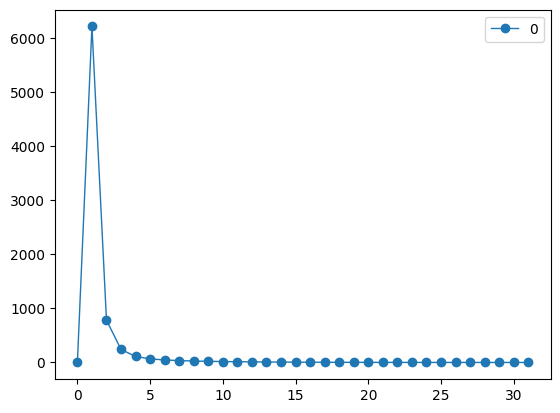

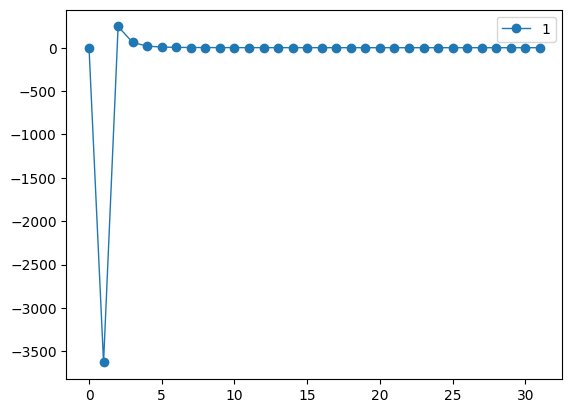

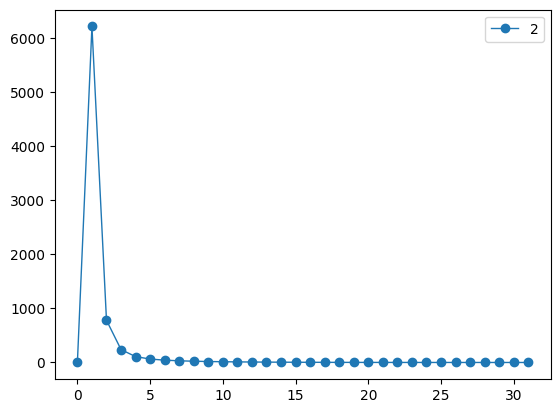

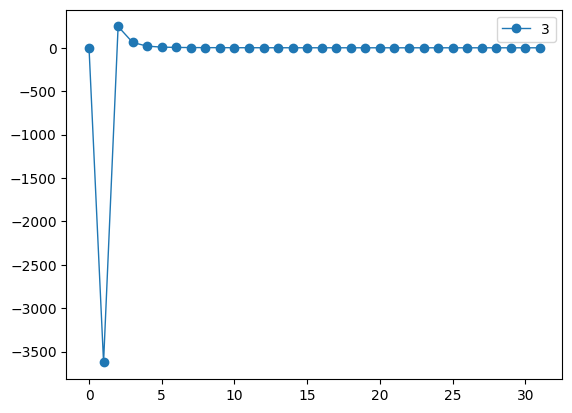

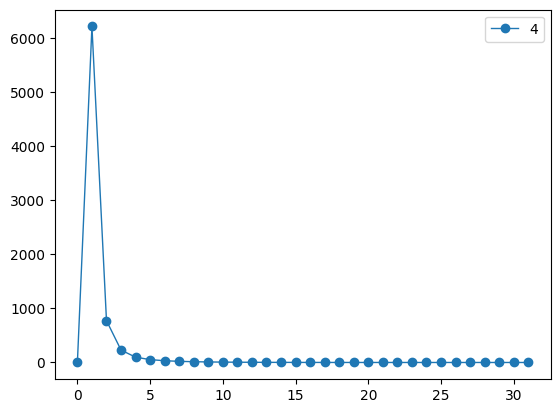

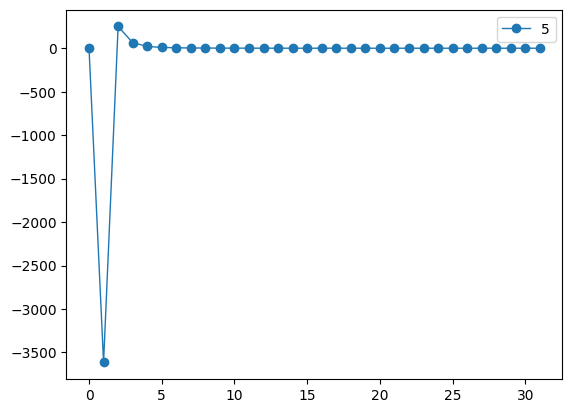

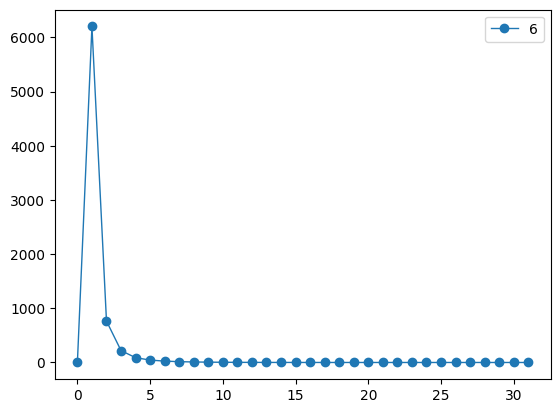

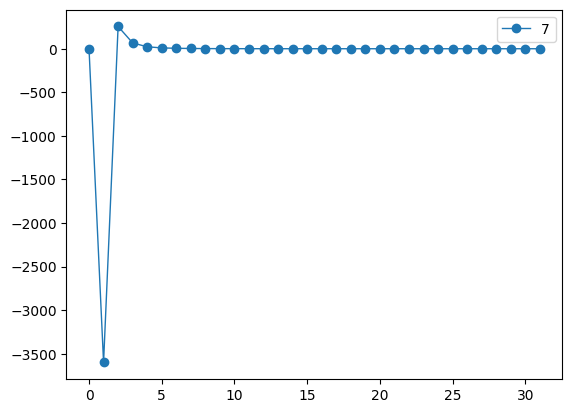

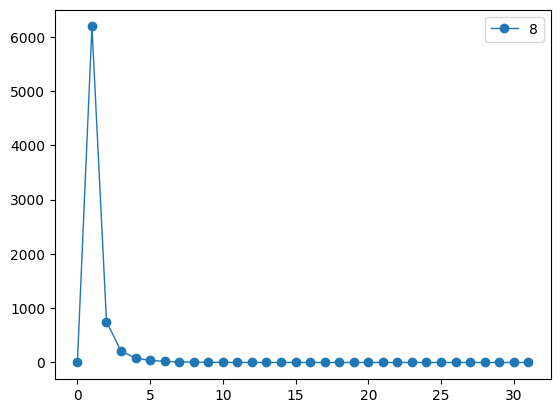

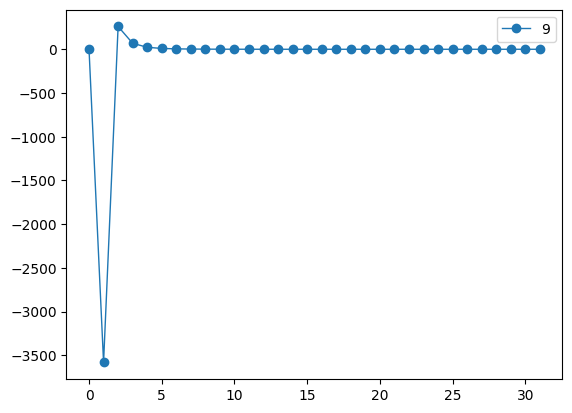

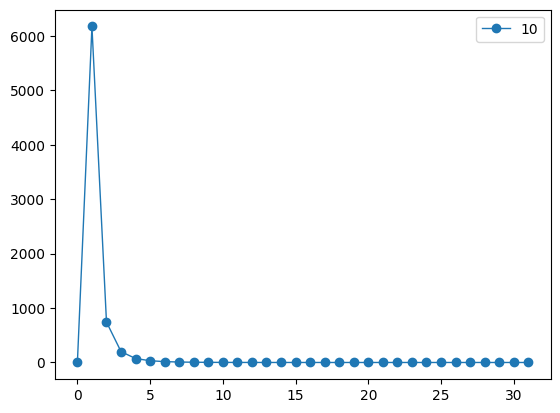

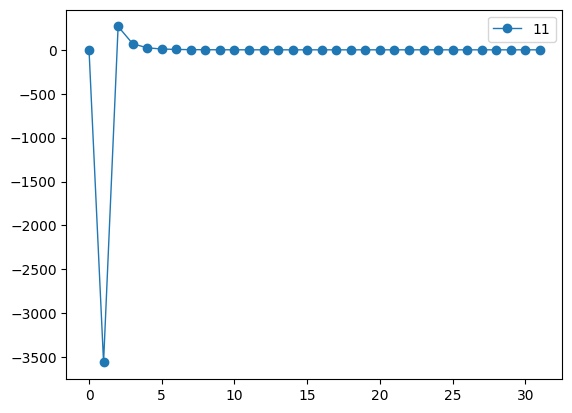

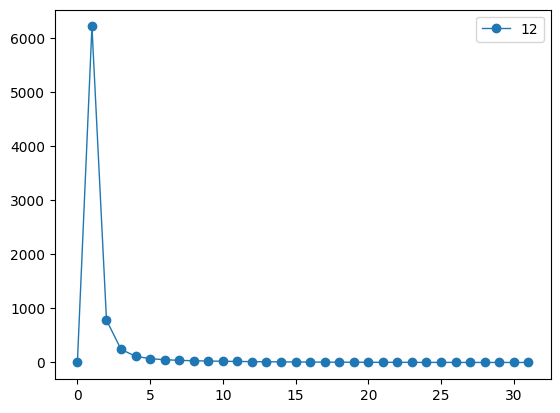

In [95]:
times = np.arange(tvals)

for ic in range(ncorr):
    _=plt.figure()
    _=plt.plot(times,np.mean(corr_navg[:,ic,:],axis=0), '-o',linewidth = 1,label=str(ic))
    _=plt.legend()

# Jacknife with effective and fit mass

In [96]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )/len(data_std)
    
def fit_sinh_x(t,amp,mass):
    T=tvals-1
    return amp*np.sinh(mass*(T-t)) #tvals-1 because T=tvals-1

def mass(corr_ratio,t,max_it=150,verb=False):

    eps=3e-7

    Time = tvals-1

    m0 = np.log(corr_ratio)

    massa = m0 #at iteration 0 the sinh is an exp and the mass is simply the log of the ration of correlators

    if corr_ratio <1.0:
        massa = 0
        return massa

    for it in range(max_it):


        '''
        if tvals-2*(t-1) -2 == 0 or tvals-2*(t-1) +2 ==0:
           break
        '''        
        

        #computes new mass from previous one
        
        #new_m = np.log(corr_ratio * (1-np.exp(-2*old_m*(tvals-t-1)))/(1-np.exp(-2*old_m*(tvals-t)) ) )

        den = 1 - np.exp( -2*massa * ( Time-t  ) )
        num = 1 - np.exp( -2*massa * ( Time-t-1) )
        #den = 1 + np.exp( -2*massa * ( Time-t  ) )
        #num = 1 + np.exp( -2*massa * ( Time-t-1) )
        

        new_massa = np.log( corr_ratio * num/den )

        if it%5 == 0 and verb==True:
            print(f"x t{t} it{it} delta = {np.abs((new_massa-massa)/massa)} \n")
        
        '''
        if np.abs(new_massa)>4.0 or new_massa<0:
            massa = 10
            break
        '''

        
        if np.abs(massa-new_massa)/massa < eps:
            massa=new_massa
            break
        

        massa = new_massa

    return massa

## Average over Noise

In [97]:
#it is already done above
if verbose:
    print("(nconf,ncorr,tvals)")
    print(np.shape(corr_navg))

(nconf,ncorr,tvals)
(100, 14, 32)


## Creation of jackknife Replicates

In [98]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 14, 32)


## Correlator Identification

In [99]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#this is the array with the replicates !!!
eff_mass_array = np.empty(shape=(ncorr,nresamples,tvals-1),dtype=float)
fit_mass_array = np.empty(shape=(ncorr,nresamples),dtype=float)
fit_amp_array = np.empty(shape=(ncorr,nresamples),dtype=float)

#chi2_array = np.empty(shape=(ncorr,nresamples),dtype=float)

chosen_maxit = 2000

#then we estimate the mass
for icorr in range(ncorr):


    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    

    
    for ires in range(nresamples):
        
        for t in range(tvals-1):
            #insert here the formula for the mass:
            eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t] /  corr_navg_resamp_gavg[ires,icorr,t+1] , t,max_it=chosen_maxit)

        
        #mass from fit for each of the replicate
        guess_amp=corr_navg_resamp_gavg[ires,icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_mass )
        guess=[guess_amp,guess_mass]
        fit_data=corr_navg_resamp_gavg[ires,icorr,cut:-cut]
        popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess,maxfev = 1300)
        perr_x = np.sqrt(np.diag(pcov_x))
        fit_mass_array[icorr,ires] = popt_x[1]
        fit_amp_array[icorr,ires] = popt_x[0]



#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

#this is the array with the mass computed on the whole dataset !!!
eff_mass_array_jacktotal = np.empty(shape=(ncorr,tvals-1),dtype=float)
fit_mass_array_jacktotal = np.empty(shape=(ncorr),dtype=float)
fit_amp_array_jacktotal = np.empty(shape=(ncorr),dtype=float)


for icorr in range(ncorr):

    #preparation for fit
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]

    
    for t in range(tvals-1):
        eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t] / corr_navg_gavg[icorr,t+1] , t, verb=False, max_it=chosen_maxit)
        

    #mass from fit for each of the replicate
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_mass )
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut]
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess,maxfev = 1200)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]




if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

/tmp/ipykernel_70944/2291156380.py:14: RuntimeWarning: divide by zero encountered in log
  m0 = np.log(corr_ratio)
/tmp/ipykernel_70944/3013304493.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array[icorr,ires,t] = mass( corr_navg_resamp_gavg[ires,icorr,t] /  corr_navg_resamp_gavg[ires,icorr,t+1] , t,max_it=chosen_maxit)
/tmp/ipykernel_70944/2291156380.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  num = 1 - np.exp( -2*massa * ( Time-t-1) )
/tmp/ipykernel_70944/2291156380.py:14: RuntimeWarning: invalid value encountered in log
  m0 = np.log(corr_ratio)


(nresamples,ncorr,tvals)
(100, 14, 32)
(ncorr,tvals)
(14, 32)


/tmp/ipykernel_70944/3013304493.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_array_jacktotal[icorr,t] = mass( corr_navg_gavg[icorr,t] / corr_navg_gavg[icorr,t+1] , t, verb=False, max_it=chosen_maxit)


In [100]:
#the estimate is the mean of the replicates
eff_estimate = np.mean(eff_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
eff_bias = (nresamples-1) * (eff_estimate-eff_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
eff_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (eff_mass_array[icorr] - eff_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
eff_estimate_biascorr = eff_estimate-eff_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(eff_estimate_biascorr))
    print(np.shape(eff_std))


#the estimate is the mean of the replicates
fit_estimate = np.mean(fit_mass_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
fit_bias = (nresamples-1) * (fit_estimate-fit_mass_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_mass_array[icorr] - fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
fit_estimate_biascorr = fit_estimate-fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))


#the estimate is the mean of the replicates
amp_fit_estimate = np.mean(fit_amp_array,axis=1) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
amp_fit_bias = (nresamples-1) * (amp_fit_estimate-fit_amp_array_jacktotal)
#the std is given by the following formula (variance of replicates times n-1)
amp_fit_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (fit_amp_array[icorr] - amp_fit_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
amp_fit_estimate_biascorr = amp_fit_estimate-amp_fit_bias

if verbose:
    print("(ncorr)")
    print(np.shape(fit_estimate_biascorr))
    print(np.shape(fit_std))

(ncorr,tvals)
(14, 31)
(14, 31)
(ncorr)
(14,)
(14,)
(ncorr)
(14,)
(14,)


In [101]:
M_fit = fit_estimate_biascorr
M_fit_std = fit_std

amp_fit = amp_fit_estimate_biascorr
amp_fit_std = amp_fit_std

In [104]:
cut = 6

#left_cut=16
#right_cut=8
left_cut=cut
right_cut=cut#+5

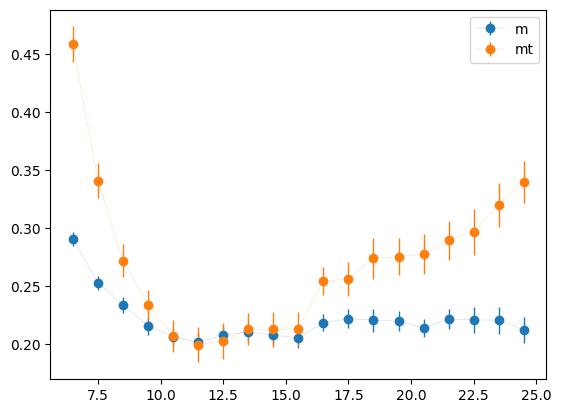

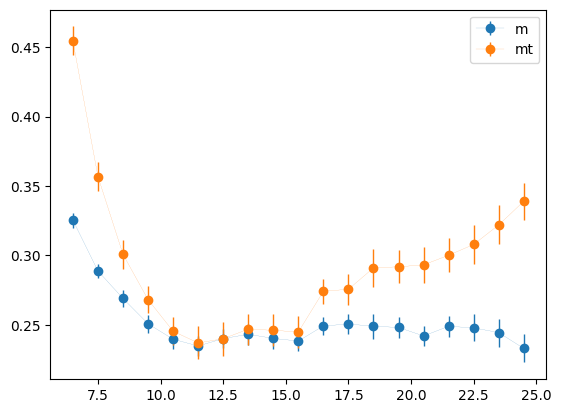

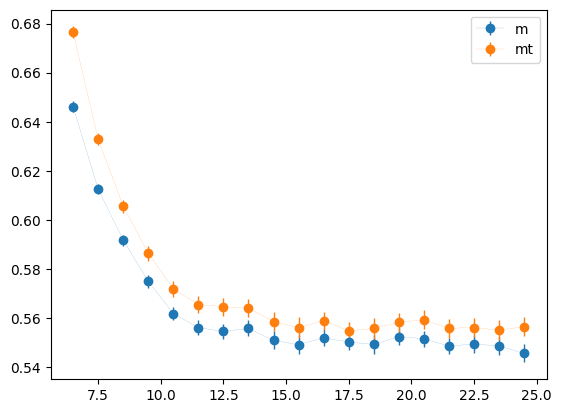

In [105]:
#check on correctness of plateau
#eff_estimate_biascorr[1::2,cut:-cut]

mass_times = times[left_cut:-right_cut-1]+0.5

for icorr in range(0,ncorr,2):
    _=plt.figure()
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr,left_cut:-right_cut],yerr=eff_std[icorr,left_cut:-right_cut],marker='o',linewidth=0.1,elinewidth=1.0,label='m')
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr+1,left_cut:-right_cut],yerr=eff_std[icorr+1,left_cut:-right_cut],marker='o',linewidth=0.1,elinewidth=1.0,label='mt')
    _=plt.legend()

In [106]:
sqM_fit = fit_estimate_biascorr**2
sqM_fit_std = 2*np.abs(fit_estimate_biascorr)*fit_std

M_eff = np.empty(shape=(ncorr),dtype=float)
M_eff_std = np.empty(shape=(ncorr),dtype=float)
chosen_cuts = np.empty(shape=(ncorr),dtype=int)

max_chi2 = 1.5

l_off = 5
r_off = 0

#plateau determination for each correlator
for icorr in range(ncorr):

    chosen_cut = int(tvals/2)-1
    
    for icut in range(3,int(tvals/2)):
        imeff = np.mean(eff_estimate_biascorr[icorr,icut+l_off:-icut-r_off])
        if chi2(imeff,eff_estimate_biascorr[icorr,icut+l_off:-icut-r_off],eff_std[icorr,icut+l_off:-icut-r_off])  < max_chi2:
            chosen_cut = icut
            chosen_cuts[icorr]=chosen_cut
            print(f"icorr{icorr}  cut{chosen_cut}")
            break
    
    M_eff[icorr] = np.mean(eff_estimate_biascorr[icorr,chosen_cut+l_off:-chosen_cut-r_off])
    M_eff_std[icorr] = np.sqrt( np.mean( eff_std[icorr,chosen_cut+l_off:-chosen_cut-r_off]**2 ) )

#M_eff = np.mean(eff_estimate_biascorr[:,left_cut:-right_cut],axis=1)
#M_eff_std = np.sqrt( np.mean( eff_std[:,left_cut:-right_cut]**2 ,axis=1 ) )
sqM_eff = M_eff**2
sqM_eff_std = 2*np.abs(M_eff)*M_eff_std

sqM_true = true_masses**2

icorr0  cut4
icorr1  cut11
icorr2  cut5
icorr3  cut11
icorr4  cut6
icorr5  cut7
icorr6  cut6
icorr7  cut6
icorr8  cut6
icorr9  cut5
icorr10  cut6
icorr11  cut6
icorr12  cut4
icorr13  cut11


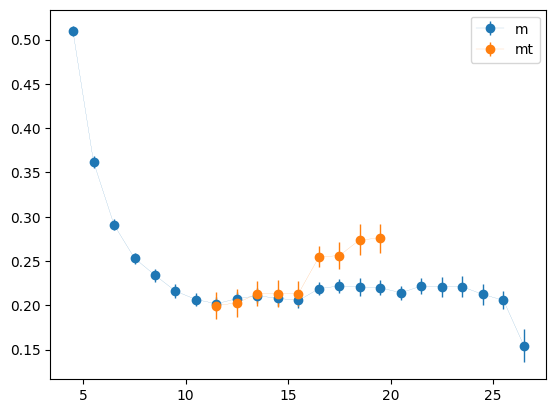

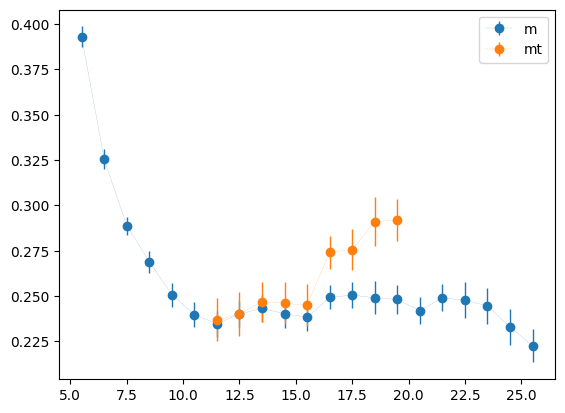

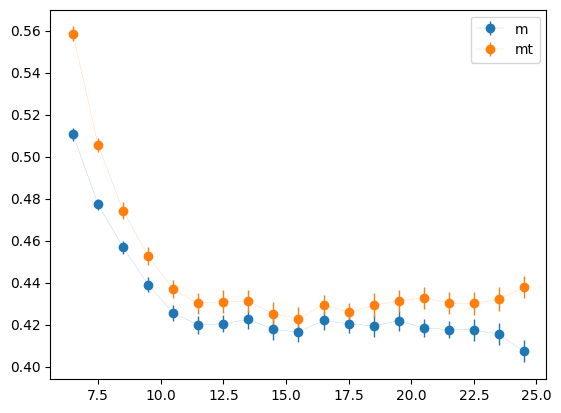

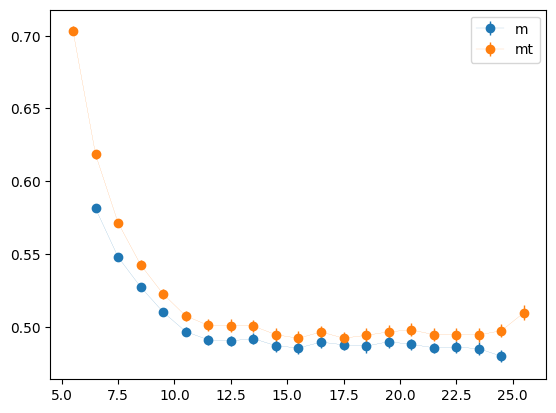

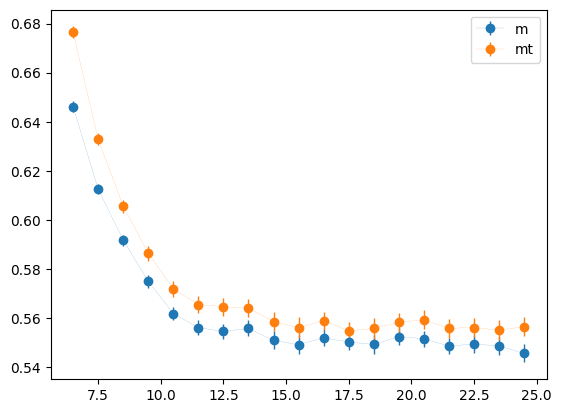

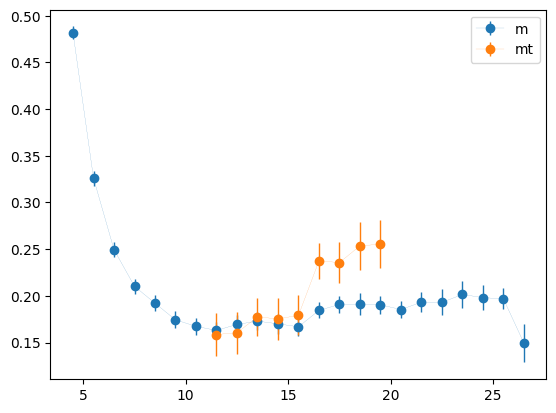

In [107]:

for icorr in range(0,ncorr,2):
    _=plt.figure()
    cut_m=chosen_cuts[icorr]
    mass_times = times[cut_m:-cut_m-1]+0.5
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr,cut_m:-cut_m],yerr=eff_std[icorr,cut_m:-cut_m],marker='o',linewidth=0.1,elinewidth=1.0,label='m')
    cut_mt=chosen_cuts[icorr+1]
    mass_times = times[cut_mt:-cut_mt-1]+0.5
    _=plt.errorbar(mass_times,eff_estimate_biascorr[icorr+1,cut_mt:-cut_mt],yerr=eff_std[icorr+1,cut_mt:-cut_mt],marker='o',linewidth=0.1,elinewidth=1.0,label='mt')
    _=plt.legend()

In [108]:
#M-Mtilda division

M2_fit = sqM_fit[::2]
M2_fit_std = sqM_fit_std[::2]

M2t_fit = sqM_fit[1::2]
M2t_fit_std = sqM_fit_std[1::2]


M2_eff = sqM_eff[::2]
M2_eff_std = sqM_eff_std[::2]

M2t_eff = sqM_eff[1::2]
M2t_eff_std = sqM_eff_std[1::2]

In [109]:
def fit_lin(x,m,q):
    return m * x + q

#mu_range = np.linspace(0,np.max(mu1)*1.1,100)
mu_range = np.linspace(0,np.max(mu1)*1.1,100)


guess_par = [ ( M2_fit[-1]-M2_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_fit, sigma= M2_fit_std, p0=guess_par)
M2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 fit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2t_fit[-1]-M2t_fit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_fit, sigma= M2t_fit_std, p0=guess_par)
M2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2t fit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2_eff[-1]-M2_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2_eff, sigma= M2_eff_std, p0=guess_par)
M2_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 eff")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( M2t_eff[-1]-M2t_eff[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, M2t_eff, sigma= M2t_eff_std, p0=guess_par)
M2t_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2t eff")
print(popt)
print(np.sqrt(np.diag(pcov)))


guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


M2 fit
[ 4.45189016 -0.00582875]
[0.04975852 0.00185221]

M2t fit
[ 4.64080283e+00 -3.12452888e-03]
[0.03360356 0.00162624]

M2 eff
[ 3.97923453e+00 -1.55070581e-03]
[0.05687332 0.00249116]

M2t eff
[3.81570904 0.01821312]
[0.11697954 0.00606264]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]


In [126]:
def do_my_plot(fit=True,eff=True,truem=True,dirfit=False,save=False):

    _=plt.figure(dpi=1200)

    if fit:
        _=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
        _=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
        _=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
        _=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

    if eff:
        _=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
        _=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
        _=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
        _=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)
    
    
    if truem:
        _=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
        _=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


    #_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
    #_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

    if dirfit:
        _=plt.errorbar(mus,m2_dirfit,yerr=m2_sig_dirfit,marker='^',linewidth=0,label=r"m dirfit",color='purple',alpha=0.6)
        _=plt.errorbar(mus,m2t_dirfit,yerr=m2t_sig_dirfit,marker='v',linewidth=0,label=r"mt dirfit",color='brown',alpha=0.6)
    
    #_=plt.errorbar(mus,excM2[::2],excM2_std[::2],marker='^',linewidth=0,elinewidth=1.0,label=r"excM2",color='purple',alpha=0.6)
    #_=plt.errorbar(mus,excM2[1::2],excM2_std[1::2],marker='v',linewidth=0,elinewidth=1.0,label=r"excM2_t",color='magenta',alpha=0.6)
    
    #_=plt.xlim((0,np.max(mu1)*1.1))
    _=plt.xlim((0,np.max(mu1)*1.1))
    
    _=plt.xlabel(r"$\mu$")
    
    
    _=plt.legend()


    _=plt.grid()

    
    _=plt.title(r"$m^2$ vs $\mu$")
    _=plt.ylabel(r"$m^2$")
    _=plt.tight_layout()

    if save != False:
        plt.savefig(save)

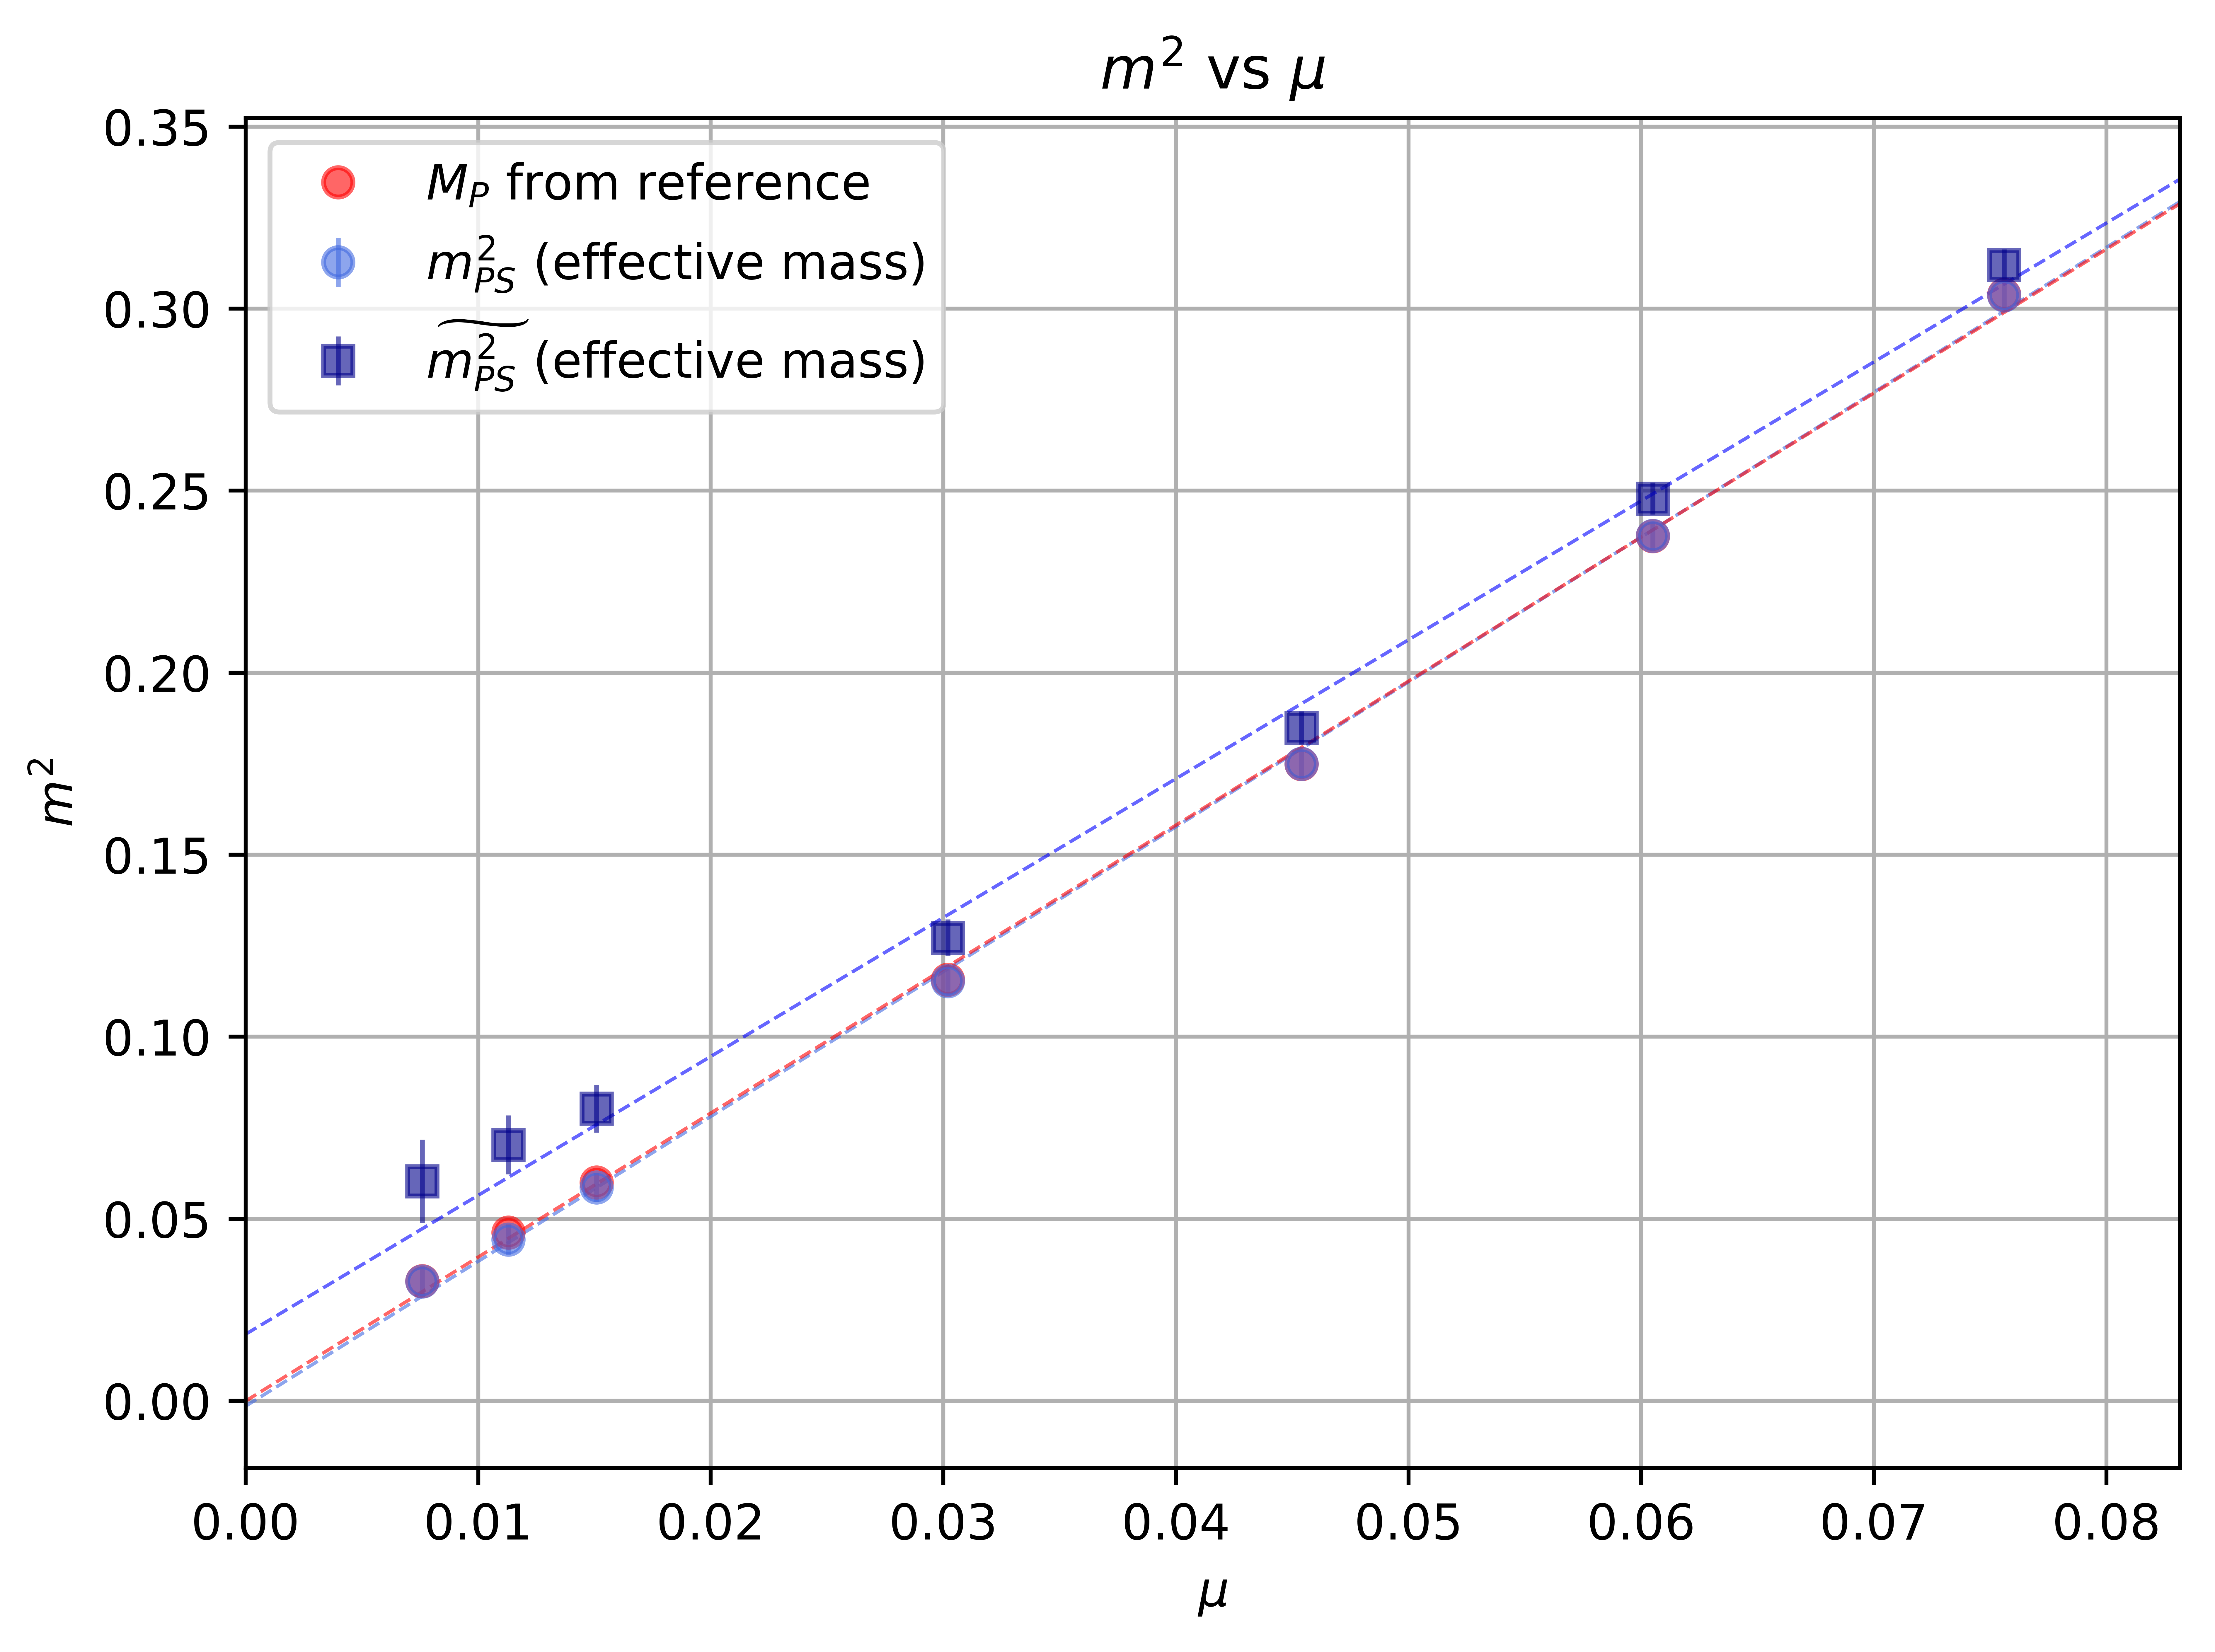

In [127]:
do_my_plot(fit=False,save='mass_scaling_20240910.png')

In [114]:
print("\nM2 eff - true")
chi2(sqM_true,M2_eff,M2_eff_std) 

print("\nM2t eff - true ")
chi2(sqM_true,M2t_eff,M2t_eff_std) 

print("\nM2 fit - true ")
chi2(sqM_true,M2_fit,M2_fit_std) 

print("\nM2t fit - true")
chi2(sqM_true,M2t_fit,M2t_fit_std)

print("\nM2 fit vs eff")
chi2(M2_fit,M2_eff,M2_eff_std) 

print("\nM2t fit vs eff")
chi2(M2t_fit,M2t_eff,M2t_eff_std)

#chi2(sqM_true,excM2[::2],excM2_std[::2])
#chi2(sqM_true,excM2[1::2],excM2_std[1::2])


M2 eff - true


np.float64(0.052301179791117744)


M2t eff - true 


np.float64(6.20582256240191)


M2 fit - true 


np.float64(65.55137270454149)


M2t fit - true


np.float64(92.01341321346965)


M2 fit vs eff


np.float64(19.395069748352864)


M2t fit vs eff


np.float64(22.862417124525134)

# Fit Check

## Correlators from Jackknife

In [115]:
delta = 1 #binning of the jackknife procedure (we delete delta conf for each replicate

corr_navg_resamp = np.asarray( [np.delete(corr_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0) for iconf in range(0,nconf,delta)] )

nresamples = int(nconf/delta)


if verbose:
    print("(nresamples,nconf-delta,ncorr,tvals)")
    print(np.shape(corr_navg_resamp))

(nresamples,nconf-delta,ncorr,tvals)
(100, 99, 14, 32)


In [116]:
#first we take the correlator averaged over the gauge configurations (for each subsample)
corr_navg_resamp_gavg = corr_navg_resamp.mean(axis=1)

#we then estimate the mass also on the whole dataset
corr_navg_gavg = corr_navg.mean(axis=0)

if verbose:
    print("(nresamples,ncorr,tvals)")
    print(np.shape(corr_navg_resamp_gavg))
    print("(ncorr,tvals)")
    print(np.shape(corr_navg_gavg))

(nresamples,ncorr,tvals)
(100, 14, 32)
(ncorr,tvals)
(14, 32)


In [117]:
#the estimate is the mean of the replicates
corr_estimate = np.mean(corr_navg_resamp_gavg,axis=0) #(the replicate axis)
#the bias is the following difference between the mean of the replicates and the mean on the whole dataset
corr_bias = (nresamples-1) * (corr_estimate-corr_navg_gavg)
#the std is given by the following formula (variance of replicates times n-1)
corr_std = np.array( [np.sqrt( (nresamples-1)/nresamples * np.sum( (corr_navg_resamp_gavg[:,icorr] - corr_estimate[icorr])**2,axis=0 ) ) for icorr in range(ncorr)]   ) 
#then we correct the estimate for the bias
corr_estimate_biascorr = corr_estimate-corr_bias

if verbose:
    print("(ncorr,tvals)")
    print(np.shape(corr_estimate_biascorr))
    print(np.shape(corr_std))

(ncorr,tvals)
(14, 32)
(14, 32)


## sinh fit

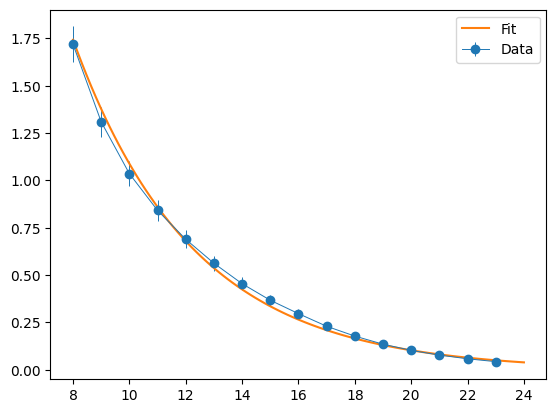

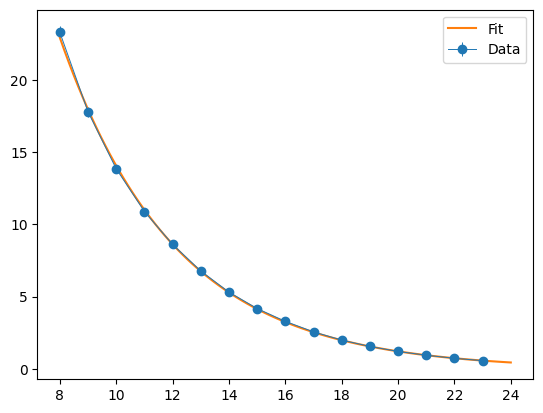

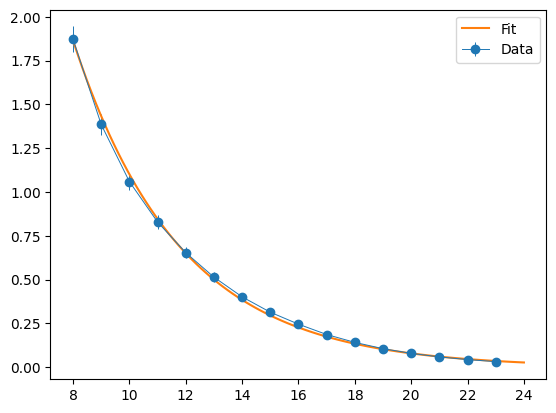

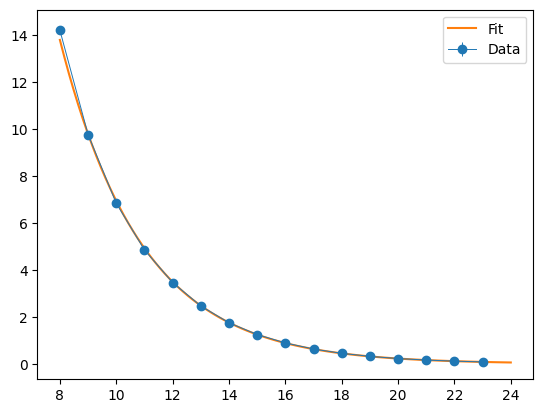

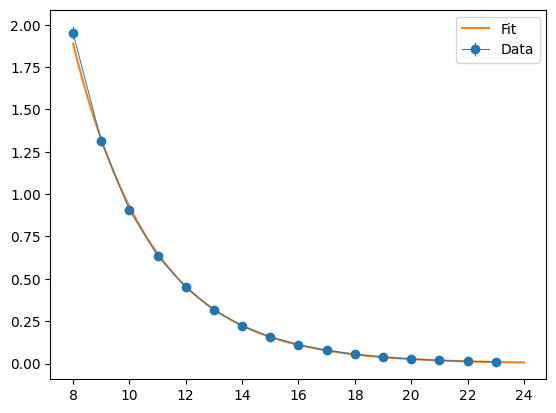

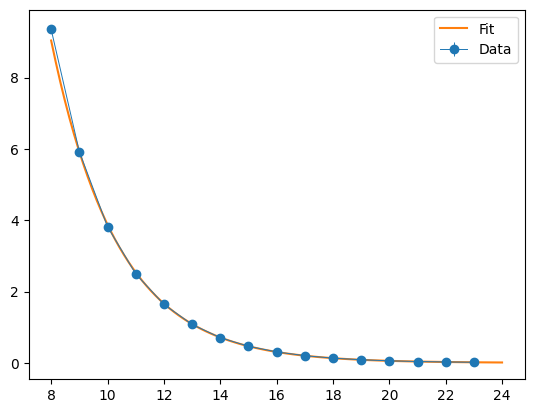

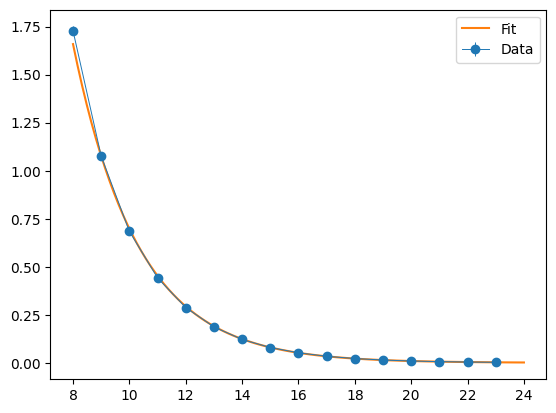

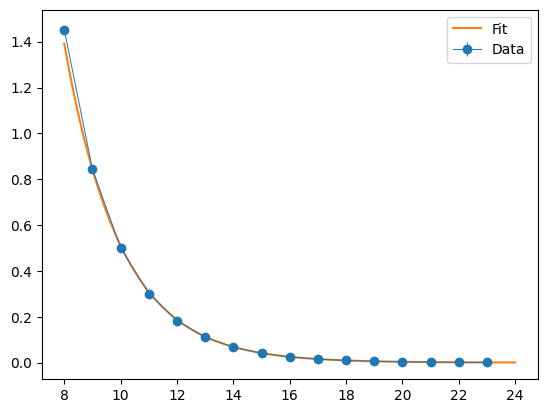

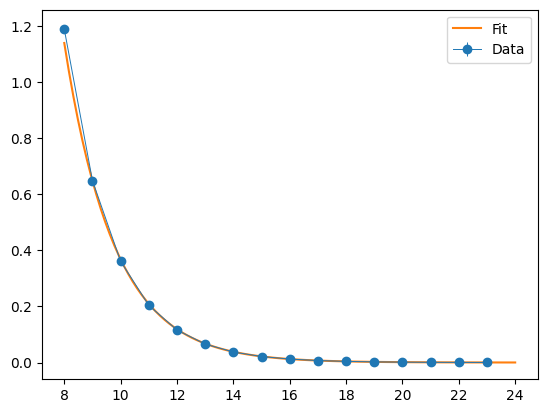

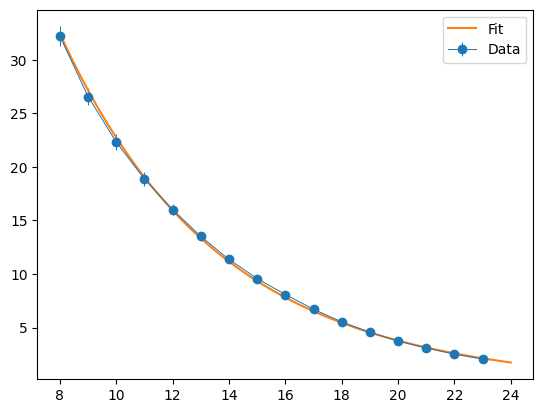

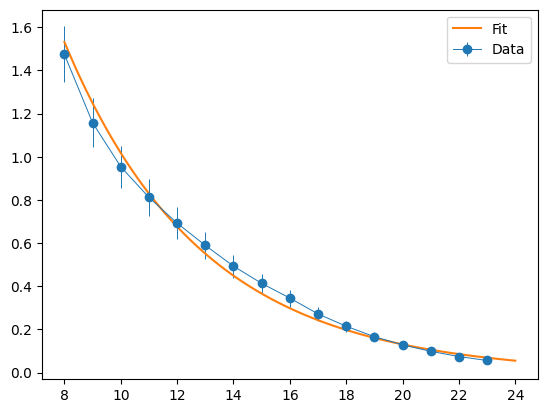

In [36]:
#fit on correlators
cut=8
times = np.arange(tvals)
fit_times=times[cut:-cut]
npoints=100
linspace_times = np.linspace(cut,tvals-cut,npoints)



mass_directfit = np.empty(shape=(ncorr),dtype=float)
mass_sig_directfit = np.empty(shape=(ncorr),dtype=float)
amp_directfit = np.empty(shape=(ncorr),dtype=float)

corr_directfit = np.empty(shape=(ncorr,npoints),dtype=float)


chi2_directfit = np.empty(shape=(ncorr),dtype=float)

#loop over correlators
for icorr in range(ncorr):


    guess_mass=true_masses[int(icorr/2)]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    
    fit_data=corr_estimate_biascorr[icorr,cut:-cut]
    fit_std=corr_std[icorr,cut:-cut]
    
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, sigma=fit_std, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    mass_directfit[icorr] = popt_x[1]
    mass_sig_directfit[icorr] = perr_x[1]
    amp_directfit[icorr] = popt_x[0]
    corr_directfit[icorr] = fit_sinh_x(linspace_times,*popt_x)

    fit_result = fit_sinh_x(fit_times,*popt_x)

    chi2_directfit[icorr] = chi2(fit_result,fit_data,fit_std)


    _=plt.figure()
    _=plt.errorbar(times[cut:-cut],fit_data,corr_std[icorr,cut:-cut],marker='o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_directfit[icorr],label='Fit')
    #_=plt.xlim(cut,tvals-cut)
    #_=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()

In [37]:
print("\nM2 dirfit chi2")
chi2_directfit[::2]

print("\nM2t dirfit chi2")
chi2_directfit[1::2]


M2 dirfit chi2


array([0.20383895, 0.17298667, 0.6381316 , 1.68822436, 3.12627601,
       4.79691997, 0.36304392])


M2t dirfit chi2


array([0.69935793, 0.58343542, 0.38774226, 1.1042951 , 2.29533474,
       3.71170216, 0.59543127])

In [38]:
mass_directfit[::2]
mass_sig_directfit[::2]

mass_directfit[1::2]
mass_sig_directfit[1::2]

array([0.21291645, 0.24433895, 0.34348865, 0.42319469, 0.49296777,
       0.55712175, 0.17739217])

array([0.00075579, 0.0006069 , 0.0008701 , 0.00117739, 0.00138934,
       0.00153021, 0.00125637])

array([0.23548623, 0.26327258, 0.35553144, 0.4327854 , 0.50147987,
       0.56509828, 0.20439841])

array([0.00368961, 0.00252516, 0.00112262, 0.00137008, 0.00159047,
       0.00172227, 0.00517635])

In [39]:
m_dirfit = mass_directfit[::2]
m2_dirfit = mass_directfit[::2]**2
m2_sig_dirfit = 2 * np.abs(m_dirfit) * mass_sig_directfit[::2]

mt_dirfit = mass_directfit[1::2]
m2t_dirfit = mass_directfit[1::2]**2
m2t_sig_dirfit = 2 * np.abs(mt_dirfit) * mass_sig_directfit[1::2]

In [40]:
guess_par = [ ( m2_dirfit[-1]-m2_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2_dirfit, sigma= m2_sig_dirfit, p0=guess_par)
m2dirfit_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nm2 dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( m2t_dirfit[-1]-m2t_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2t_dirfit, sigma= m2t_sig_dirfit, p0=guess_par)
m2dirfit_eff_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nm2t dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


print("\nm2 dirfit - true ")
chi2(sqM_true,m2_dirfit,m2_sig_dirfit) 

print("\nm2 dirfit - eff ")
chi2(M2_eff,m2_dirfit,m2_sig_dirfit) 
chi2(M2_eff,m2_dirfit,M2_eff_std) 


m2 dirfit
[ 3.99111234e+00 -1.26301649e-04]
[0.05286235 0.00107282]

m2t dirfit
[4.04545442 0.00635309]
[0.0728571  0.00280821]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]

m2 dirfit - true 


np.float64(11.642124009717877)


m2 dirfit - eff 


np.float64(6.180543912686815)

np.float64(0.40754940781863974)

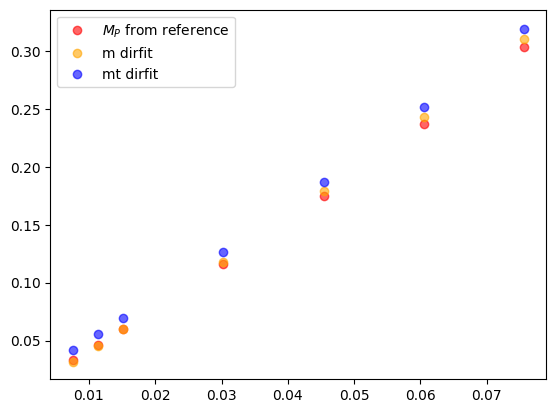

In [41]:


_=plt.errorbar(mus,m_dirfit**2,yerr=m2_sig_dirfit,marker='o',linewidth=0,label=r"m dirfit",color='orange',alpha=0.6)
_=plt.errorbar(mus,mt_dirfit**2,yerr=m2t_sig_dirfit,marker='o',linewidth=0,label=r"mt dirfit",color='blue',alpha=0.6)
_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
plt.legend()

In [42]:
'''
cut=8

#loop over correlators
for icorr in range(ncorr):






    #direct fit
    #mass from fit for each of the replicate
    guess_mass=true_masses[int(icorr/2)]
    cut=8
    fit_times=times[cut:-cut]
    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)
    guess=[guess_amp,guess_mass]
    fit_data=corr_navg_gavg[icorr,cut:-cut].real
    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)
    perr_x = np.sqrt(np.diag(pcov_x))
    fit_mass_array_jacktotal[icorr] = popt_x[1]
    fit_amp_array_jacktotal[icorr] = popt_x[0]
    



    

    corr_from_data = corr_navg_gavg[icorr]

    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])

    _=plt.figure()
    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_from_fit,label='Fit')
    _=plt.xlim(cut,tvals-cut)
    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()
    '''

"\ncut=8\n\n#loop over correlators\nfor icorr in range(ncorr):\n\n\n\n\n\n\n    #direct fit\n    #mass from fit for each of the replicate\n    guess_mass=true_masses[int(icorr/2)]\n    cut=8\n    fit_times=times[cut:-cut]\n    guess_amp=corr_navg_gavg[icorr,int(tvals/2)].real * 2 * np.exp(-tvals/2 * guess_mass)\n    guess=[guess_amp,guess_mass]\n    fit_data=corr_navg_gavg[icorr,cut:-cut].real\n    popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times, fit_data, p0=guess)\n    perr_x = np.sqrt(np.diag(pcov_x))\n    fit_mass_array_jacktotal[icorr] = popt_x[1]\n    fit_amp_array_jacktotal[icorr] = popt_x[0]\n    \n\n\n\n    \n\n    corr_from_data = corr_navg_gavg[icorr]\n\n    corr_from_fit = fit_sinh_x(linspace_times,amp_fit[icorr],M_fit[icorr])\n\n    _=plt.figure()\n    _=plt.plot(times,corr_from_data,'-o',linewidth=0.7,label='Data')\n    _=plt.plot(linspace_times,corr_from_fit,label='Fit')\n    _=plt.xlim(cut,tvals-cut)\n    _=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from

## exp fit

In [118]:
def exp_fit(t,a1,m,b1):
    #T=tvals-1
    return a1*np.exp(-m*t) + b1*np.exp(m*t)


icorr0
[ 1.38087494e+02  2.07396947e-01 -1.79448744e-03]

icorr1
[ 8.54707091e+00  2.09532354e-01 -3.69849549e-04]

icorr2
[ 1.53919138e+02  2.40519114e-01 -3.10247620e-04]

icorr3
[ 1.24388049e+01  2.45448043e-01 -8.26149953e-05]

icorr4
[ 2.06505004e+02  3.40827280e-01 -1.41697330e-06]

icorr5
[ 2.97274695e+01  3.49312696e-01 -5.55734282e-07]

icorr6
[2.54686219e+02 4.20355909e-01 1.98784531e-08]

icorr7
[4.95201898e+01 4.28872154e-01 5.38069778e-10]

icorr8
[3.03344932e+02 4.89869698e-01 4.45552416e-09]

icorr9
[7.22182799e+01 4.98063821e-01 1.04765217e-09]

icorr10
[3.54544517e+02 5.53790173e-01 5.13823132e-10]

icorr11
[9.83689052e+01 5.61702936e-01 1.41707012e-10]

icorr12
[ 1.20516315e+02  1.67815083e-01 -1.47218712e-02]

icorr13
[ 5.22828011e+00  1.67109284e-01 -1.87092718e-03]


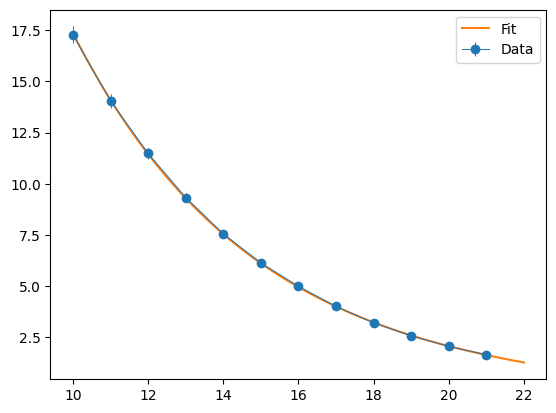

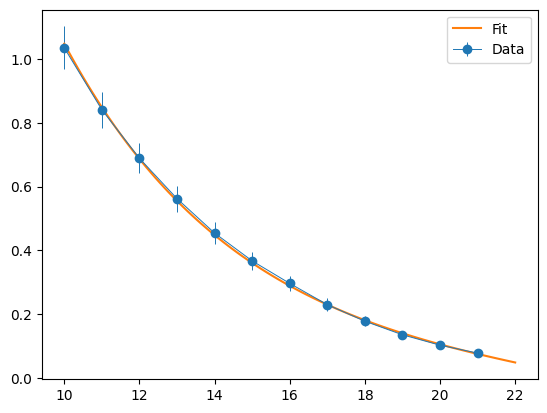

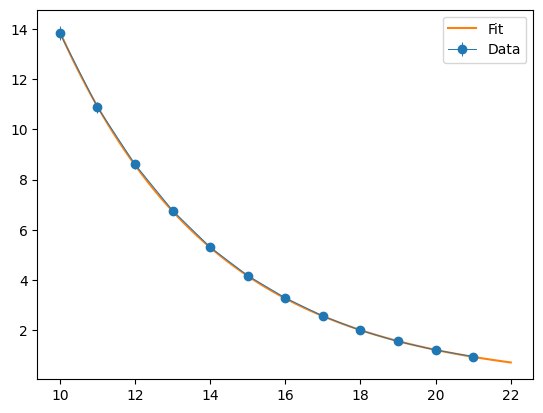

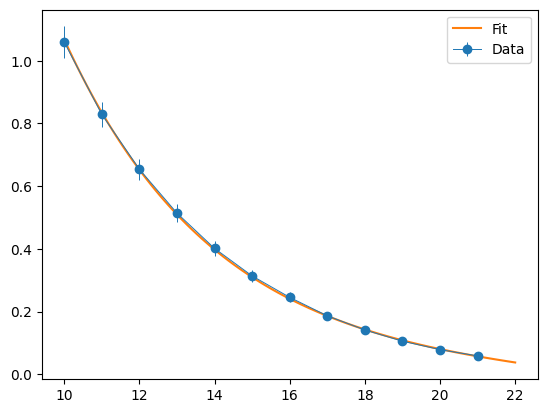

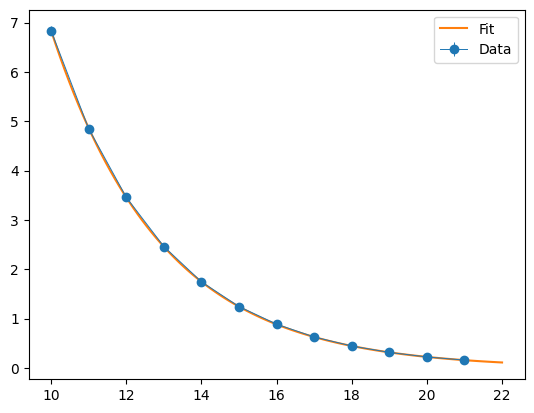

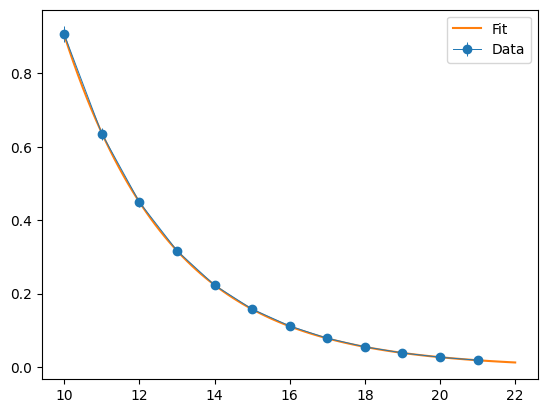

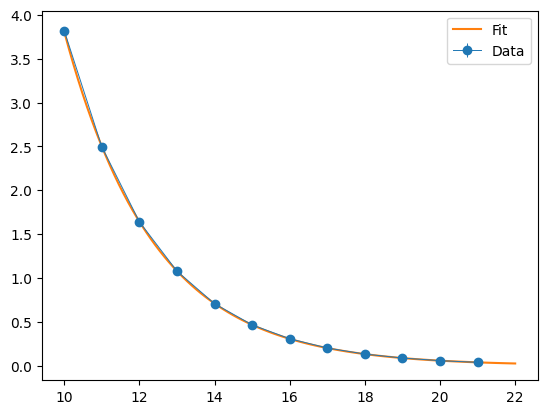

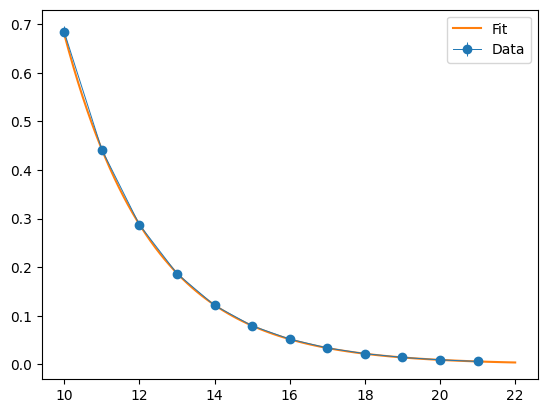

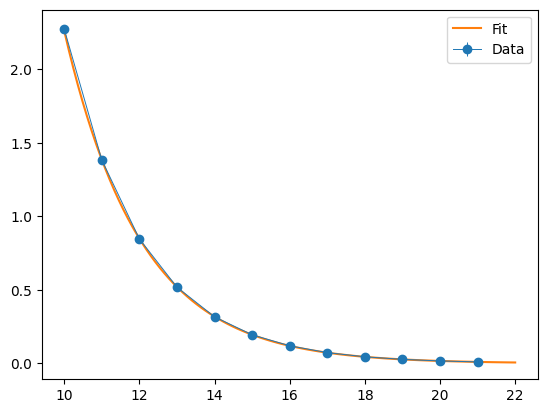

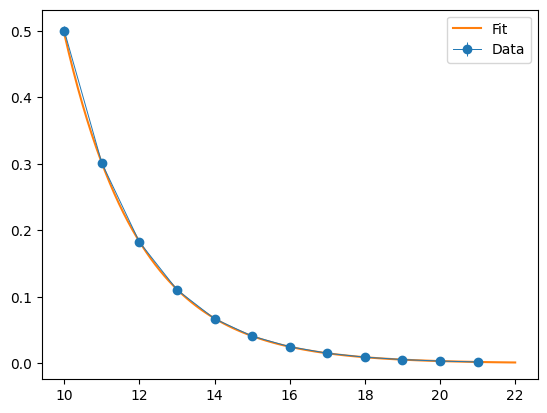

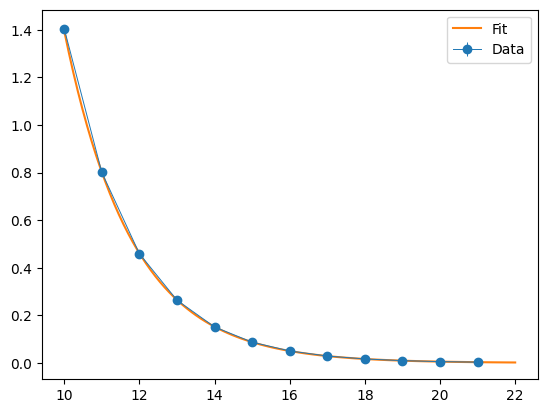

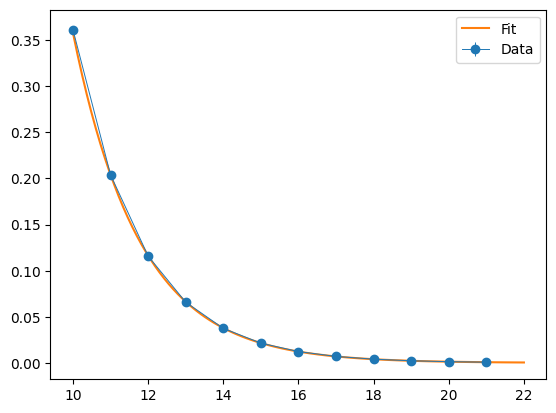

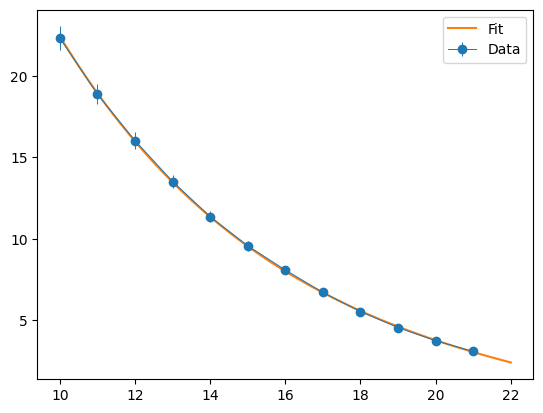

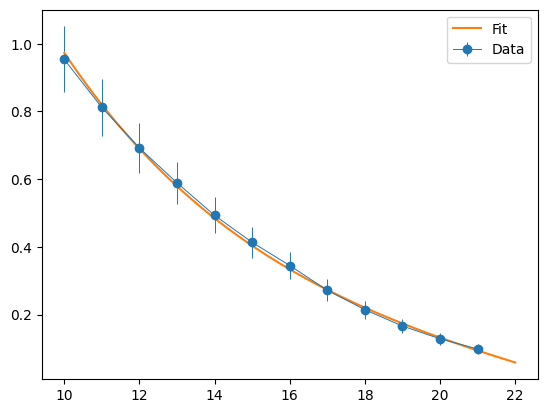

In [119]:
#fit on correlators
cut=10
times = np.arange(tvals)
fit_times=times[cut:-cut]
npoints=100
linspace_times = np.linspace(cut,tvals-cut,npoints)



mass_directfit = np.empty(shape=(ncorr),dtype=float)
mass_sig_directfit = np.empty(shape=(ncorr),dtype=float)
#amp_directfit = np.empty(shape=(ncorr),dtype=float)

corr_directfit = np.empty(shape=(ncorr,npoints),dtype=float)


chi2_directfit = np.empty(shape=(ncorr),dtype=float)

#loop over correlators
for icorr in range(ncorr):

    guess_m = true_masses[int(icorr/2)]
    
    my_amp = corr_estimate_biascorr[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_m )


    
    my_amp = corr_estimate_biascorr[icorr,int(tvals/2)] / np.sinh( (tvals-1-tvals/2) * guess_m )
    guess_a1 = my_amp * np.exp(guess_m*(tvals-1)) #corr_estimate_biascorr[icorr,int(tvals/2)] / np.exp(-tvals/2 * guess_m)
    guess_b1 = -my_amp * np.exp(-guess_m*(tvals-1)) #corr_estimate_biascorr[icorr,int(tvals/2)] / np.exp(-tvals/2 * guess_m)
    #guess_e2 = guess_m

    #guess_a1 = 1
    #guess_b1 = 1
    
    guess=[guess_a1,guess_m,guess_b1]#,guess_e2]
    
    fit_data=corr_estimate_biascorr[icorr,cut:-cut]
    fit_std=corr_std[icorr,cut:-cut]
    
    
    popt_x,pcov_x = curve_fit(exp_fit, fit_times, fit_data, sigma=fit_std, p0=guess,maxfev=5000)
    perr_x = np.sqrt(np.diag(pcov_x))

    print(f"\nicorr{icorr}")
    print(popt_x)
    
    mass_directfit[icorr] = popt_x[1]
    mass_sig_directfit[icorr] = perr_x[1]
    #amp_directfit[icorr] = popt_x[0]
    
    corr_directfit[icorr] = exp_fit(linspace_times,*popt_x)
    

    fit_result = exp_fit(fit_times,*popt_x)

    chi2_directfit[icorr] = chi2(fit_result,fit_data,fit_std)


    _=plt.figure()
    _=plt.errorbar(times[cut:-cut],fit_data,corr_std[icorr,cut:-cut],marker='o',linewidth=0.7,label='Data')
    _=plt.plot(linspace_times,corr_directfit[icorr],label='Fit')
    #_=plt.xlim(cut,tvals-cut)
    #_=plt.ylim(np.min(corr_from_data[cut:-cut])*0.9, np.max(corr_from_data[cut:-cut])*1.1 )
    _=plt.legend()

In [120]:
print("\nM2 dirfit chi2")
chi2_directfit[::2]

print("\nM2t dirfit chi2")
chi2_directfit[1::2]


M2 dirfit chi2


array([0.03852944, 0.03777192, 0.01470652, 0.02509434, 0.09542405,
       0.20934006, 0.03734146])


M2t dirfit chi2


array([0.05474852, 0.04716144, 0.00878076, 0.03631299, 0.11516208,
       0.2209488 , 0.04560539])

In [121]:
mass_directfit[::2]
mass_sig_directfit[::2]

mass_directfit[1::2]
mass_sig_directfit[1::2]

array([0.20739695, 0.24051911, 0.34082728, 0.42035591, 0.4898697 ,
       0.55379017, 0.16781508])

array([0.00102378, 0.00080223, 0.00030845, 0.00031006, 0.0005046 ,
       0.00065075, 0.00144824])

array([0.20953235, 0.24544804, 0.3493127 , 0.42887215, 0.49806382,
       0.56170294, 0.16710928])

array([0.00335169, 0.00216613, 0.00043712, 0.00059235, 0.00080303,
       0.00090929, 0.00521271])

In [122]:
m_dirfit = mass_directfit[::2]
m2_dirfit = mass_directfit[::2]**2
m2_sig_dirfit = 2 * np.abs(m_dirfit) * mass_sig_directfit[::2]

mt_dirfit = mass_directfit[1::2]
m2t_dirfit = mass_directfit[1::2]**2
m2t_sig_dirfit = 2 * np.abs(mt_dirfit) * mass_sig_directfit[1::2]

m2_dirfit
m2t_dirfit

array([0.04301349, 0.05784944, 0.11616323, 0.17669909, 0.23997232,
       0.30668356, 0.0281619 ])

array([0.04390381, 0.06024474, 0.12201936, 0.18393132, 0.24806757,
       0.31551019, 0.02792551])

In [123]:
murange = np.linspace(0,np.max(mu1)*1.1,100)

guess_par = [ ( m2_dirfit[-1]-m2_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2_dirfit, sigma= m2_sig_dirfit, p0=guess_par)
m2dirfit_eff_linfit = fit_lin(murange,*popt)
print("\nm2 dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( m2t_dirfit[-1]-m2t_dirfit[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, m2t_dirfit, sigma= m2t_sig_dirfit, p0=guess_par)
m2tdirfit_eff_linfit = fit_lin(murange,*popt)
print("\nm2t dirfit")
print(popt)
print(np.sqrt(np.diag(pcov)))

guess_par = [ ( sqM_true[-1]-sqM_true[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, sqM_true, p0=guess_par)
fit_reference = fit_lin(murange,*popt)
print("\nM2 true")
print(popt)
print(np.sqrt(np.diag(pcov)))


print("\nm2 dirfit - true ")
chi2(sqM_true,m2_dirfit,m2_sig_dirfit) 

print("\nm2 dirfit - eff ")
chi2(M2_eff,m2_dirfit,m2_sig_dirfit) 
chi2(M2_eff,m2_dirfit,M2_eff_std)

print("\nm2t dirfit - eff ")
chi2(M2t_eff,m2t_dirfit,m2t_sig_dirfit) 
chi2(M2t_eff,m2t_dirfit,M2t_eff_std)


m2 dirfit
[ 4.01265452 -0.00401601]
[0.04956    0.00180548]

m2t dirfit
[ 4.18497429 -0.00449994]
[0.03546901 0.00139755]

M2 true
[ 3.95565539e+00 -1.52047020e-04]
[0.05914152 0.00252526]

m2 dirfit - true 


np.float64(39.10202139848)


m2 dirfit - eff 


np.float64(29.313044122560882)

np.float64(0.36904977527599636)


m2t dirfit - eff 


np.float64(192.73524960603393)

np.float64(4.25932375919355)

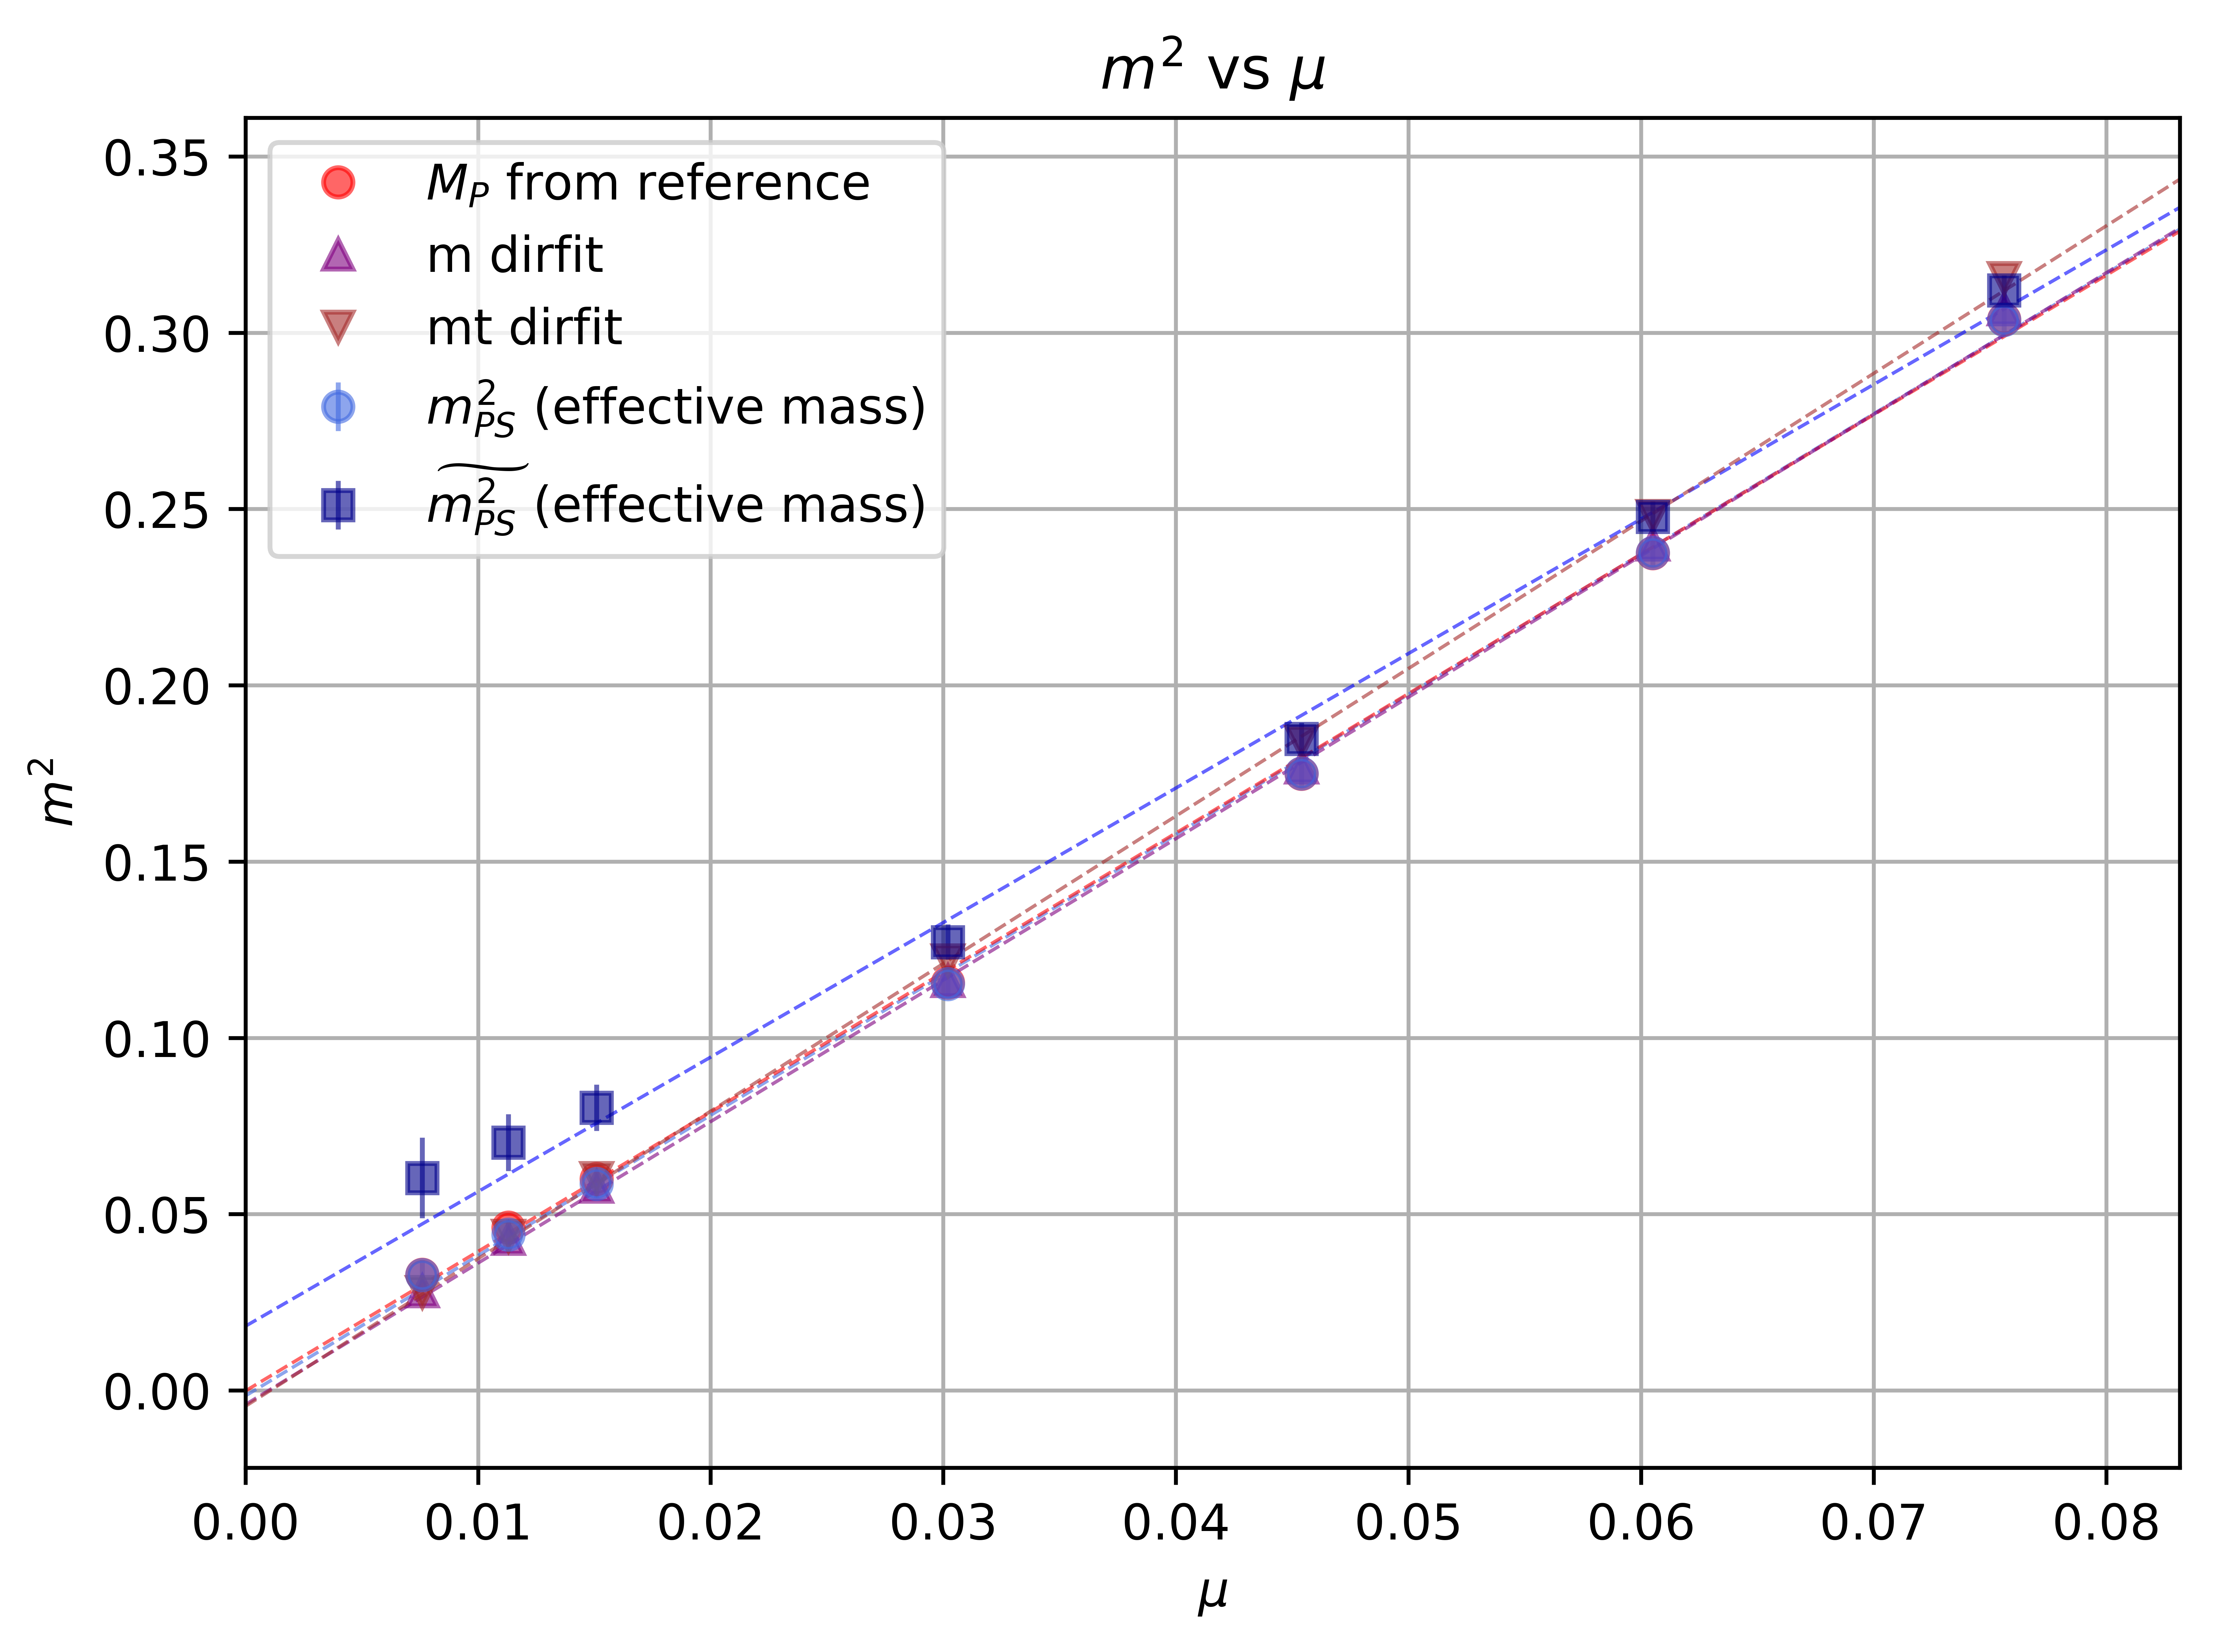

In [124]:
#do_my_plot(fit=False,eff=False,truem=False,dirfit=True)
do_my_plot(fit=False,eff=True,truem=True,dirfit=False)

_=plt.plot(mus,m2_dirfit,marker='^',linewidth=0,label=r"m dirfit",color='purple',alpha=0.6)
_=plt.plot(mu_range,m2dirfit_eff_linfit,linewidth =0.7,linestyle='dashed',color='purple',alpha=0.6)
_=plt.plot(mus,m2t_dirfit,marker='v',linewidth=0,label=r"mt dirfit",color='brown',alpha=0.6)
_=plt.plot(mu_range,m2tdirfit_eff_linfit,linewidth =0.7,linestyle='dashed',color='brown',alpha=0.6)
#_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
plt.legend()

# Extra check

In [38]:
M_eff
M_eff_std

array([0.2171663 , 0.26629198, 0.2474179 , 0.3076772 , 0.34268924,
       0.47008392, 0.42036829, 0.60487749, 0.48946829, 0.73821411,
       0.55310412, 0.8484812 , 0.18112267, 0.225131  ])

array([0.0081408 , 0.02365468, 0.00731232, 0.02498688, 0.00545738,
       0.03273853, 0.00454045, 0.04094173, 0.00387841, 0.06253846,
       0.00341277, 0.27306345, 0.00930994, 0.02354788])

In [39]:
def eff_mass_func(t,mps,E1,c1,c2):
    return mps+c1*np.exp(-E1*t)+c2*np.exp(-2*mps*(tvals-1-t))
#def eff_mass_func(t,mps,E1,c1):
 #   return mps+c1*np.exp(-E1*t)#+c2*np.exp(-2*mps*(tvals-1-t))

In [40]:
cut=4
times = np.arange(tvals)
fit_times_m=times[cut:-cut-1]+0.5

extra_check_masses = np.empty(shape=(ncorr),dtype=float)
extra_check_masses_std = np.empty(shape=(ncorr),dtype=float)

for icorr in range(ncorr):

    meff = eff_estimate_biascorr[icorr,cut:-cut]
    meff_std = eff_std[icorr,cut:-cut]
    
    guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], true_masses[int(icorr/2)], true_masses[int(icorr/2)] ]
    #guess_par = [ true_masses[int(icorr/2)] , true_masses[int(icorr/2)], 0.0 ]
    popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)

    print(popt)
    #print(pcov)
    extra_check_masses[icorr] = popt[0]
    extra_check_masses_std[icorr] = np.sqrt(np.diag(pcov))[0]

excM2 = extra_check_masses**2
excM2_std = 2*extra_check_masses*extra_check_masses_std

[0.21304996 0.68464062 6.45687354 0.37695845]
[ 0.15802688  0.16847644  0.93205554 -0.0784068 ]
[0.24415519 0.64801228 5.35093259 0.25276677]
[ 0.15150832  0.13831735  0.89804307 -0.16934468]
[ 0.34094806  0.5701463   3.59300047 -0.4500521 ]
[ 0.15873024  0.10035165  0.94805077 -0.57762822]
[ 0.41895138  0.53429862  2.99408402 -1.33591991]
[ 0.16554566  0.08244229  1.01371525 -0.97558538]
[ 0.48752796  0.5140147   2.69736336 -2.32304081]
[ 0.18468619  0.07309226  1.06788218 -1.63035663]
[ 0.55076795  0.50039356  2.51097901 -3.41622361]
[0.5512 0.5512 0.5512 0.5512]
[0.17650149 0.73471388 8.35369897 0.46393004]
[ 0.17128921  0.23610091  1.10980508 -0.01073846]


/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env_2/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:975: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/tmp/ipykernel_8326/2614299248.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(eff_mass_func, fit_times_m, meff, sigma= meff_std, p0=guess_par,maxfev=5000)


In [41]:
excM2

array([0.04539028, 0.0249725 , 0.05961176, 0.02295477, 0.11624558,
       0.02519529, 0.17552026, 0.02740537, 0.23768351, 0.03410899,
       0.30334533, 0.30382144, 0.03115278, 0.02933999])

In [42]:
mu_range = np.linspace(0,np.max(mu1)*1.1,100)

excM2_ = excM2[::2]
excM2_std_ = excM2_std[::2]
excM2_t = excM2[1::2]
excM2_std_t = excM2_std[1::2]

guess_par = [ ( excM2_[-1]+excM2_[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, excM2_, sigma= excM2_std_, p0=guess_par)
excM2_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

guess_par = [ ( excM2_t[-1]+excM2_t[0])/(mus[-1]-mus[0]) , 0.0]
popt,pcov = curve_fit(fit_lin, mus, excM2_t, sigma= excM2_std_t, p0=guess_par)
excM2t_fit_linfit = fit_lin(np.linspace(0,np.max(mu1)*1.1,100),*popt)

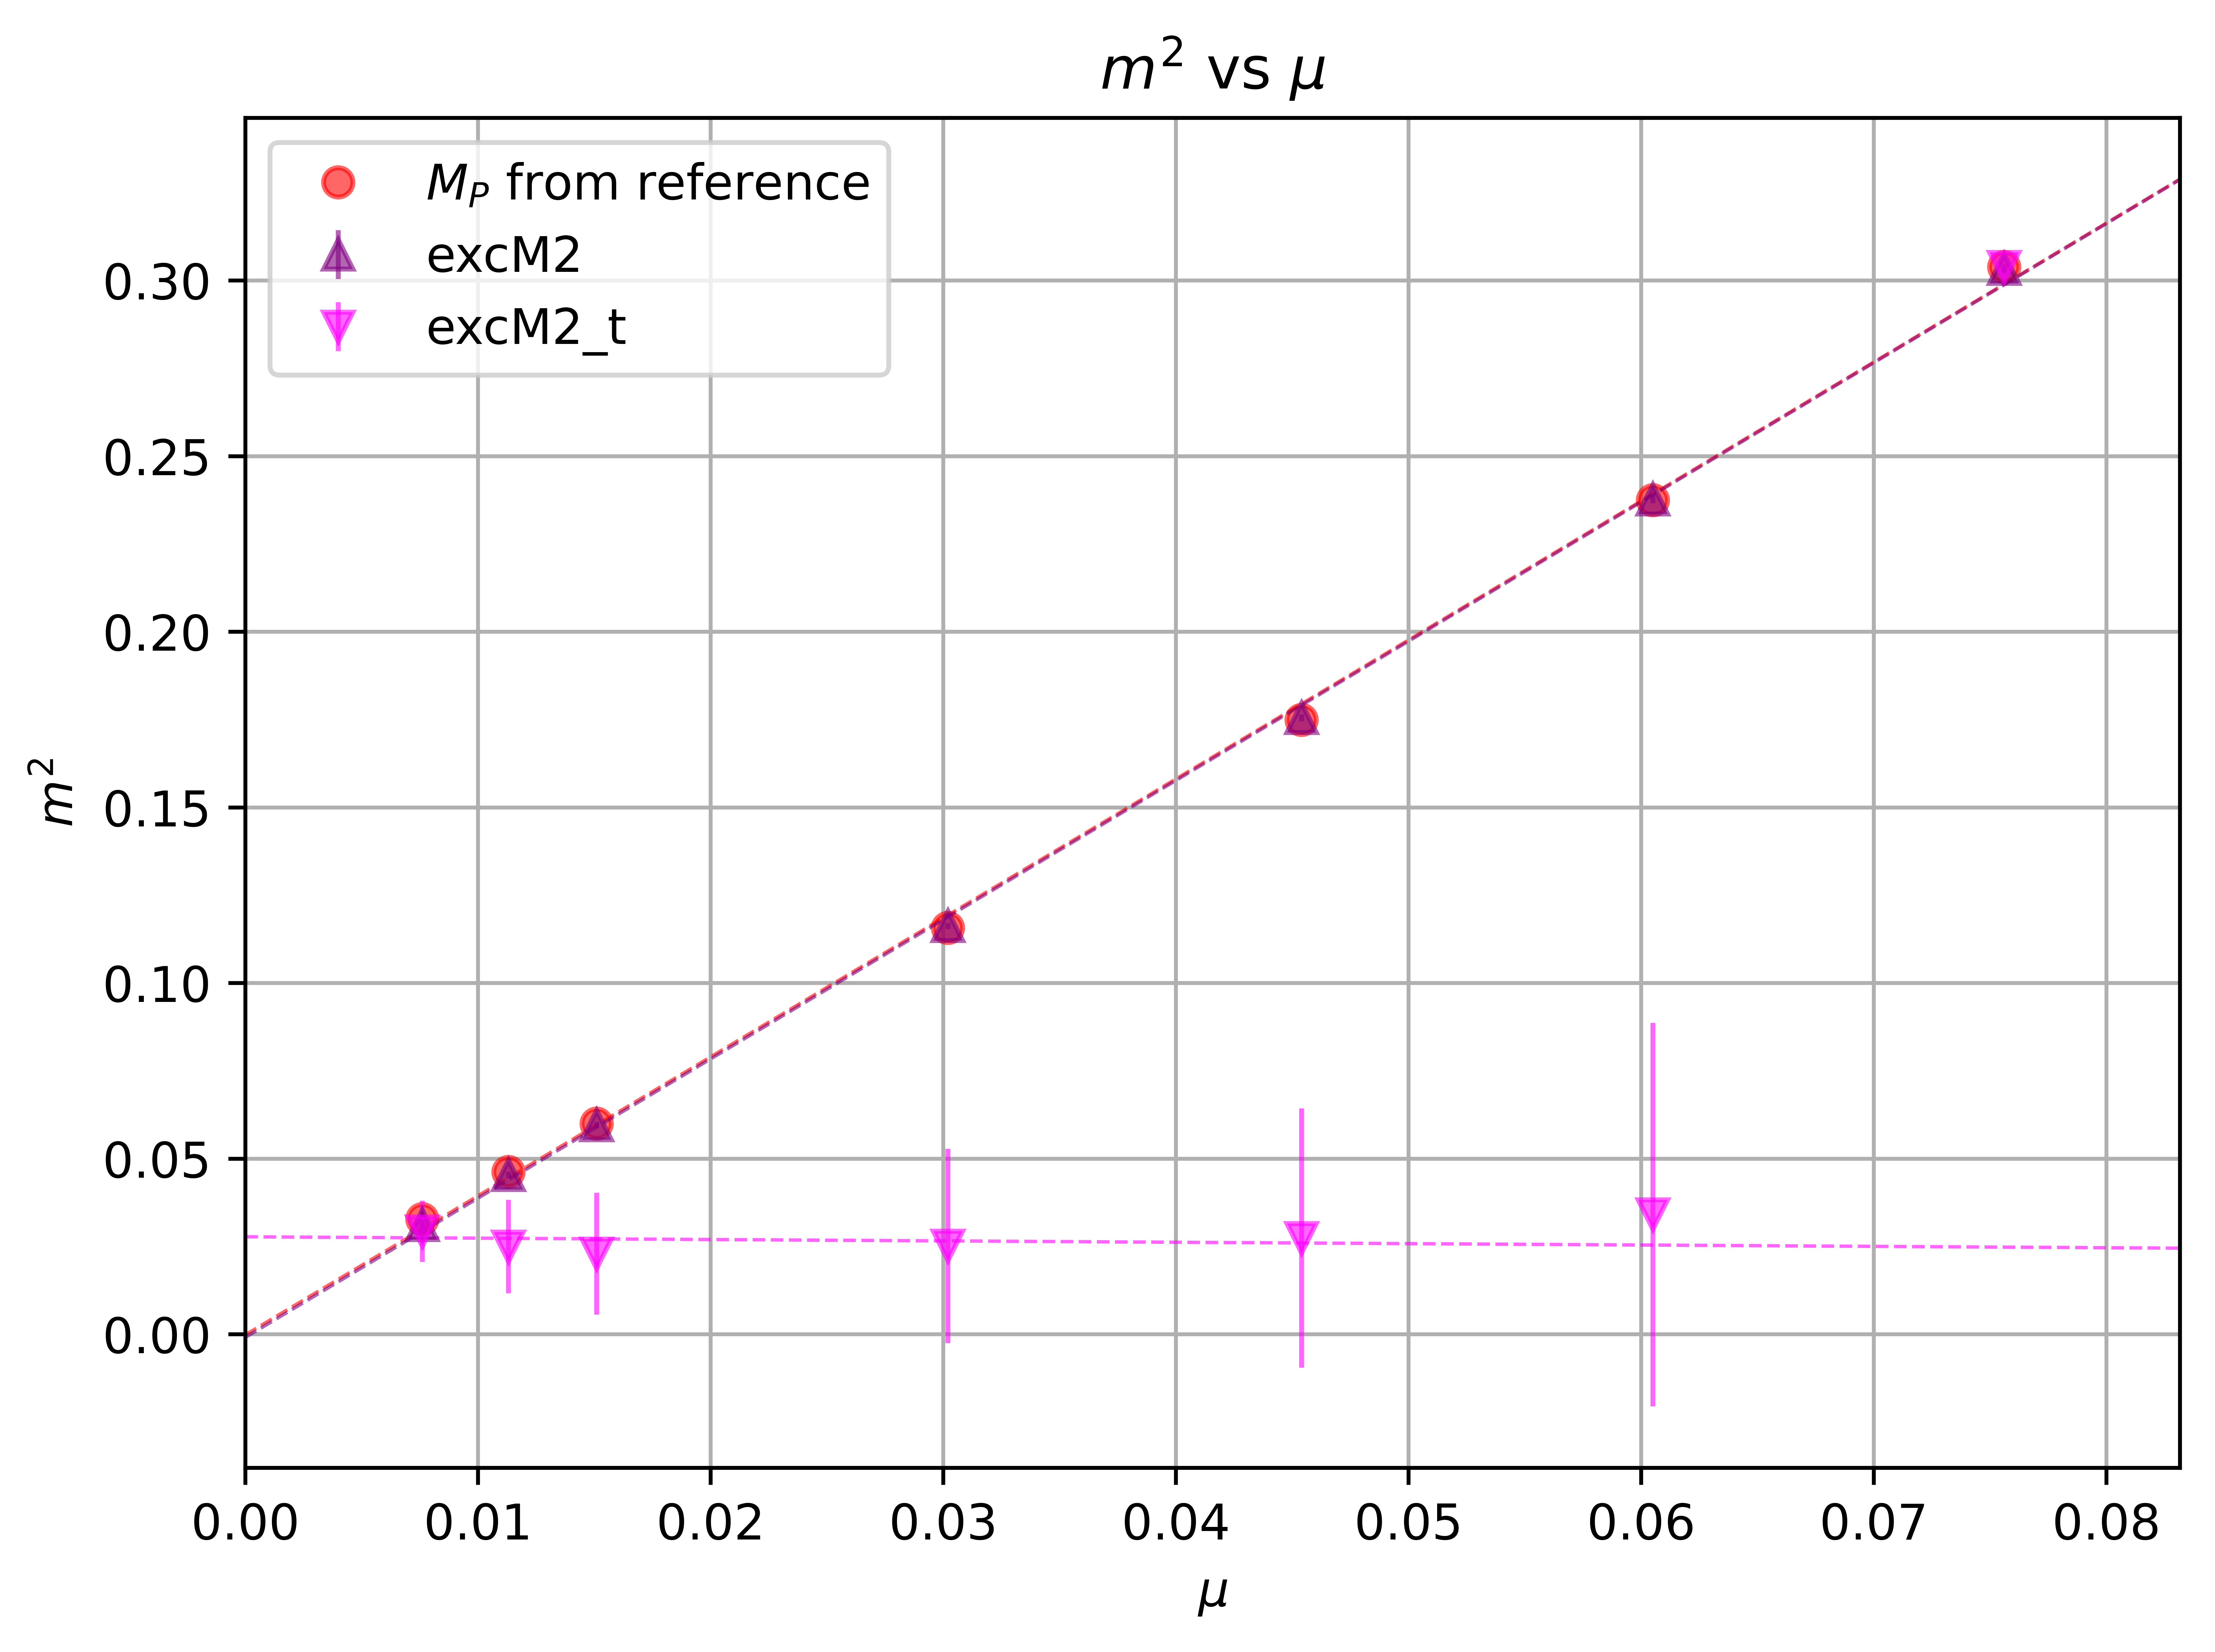

In [43]:
_=plt.figure(dpi=1200)

#_=plt.errorbar(mus,M2_fit,M2_fit_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (from sinh fit)",color='limegreen',alpha=0.6)
#_=plt.plot(mu_range,M2_fit_linfit,linewidth =0.7,linestyle='dashed',color='limegreen',alpha=0.6)
#_=plt.errorbar(mus,M2t_fit,M2t_fit_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (from sinh fit)",color='darkgreen',alpha=0.6)
#_=plt.plot(mu_range,M2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='darkgreen',alpha=0.6)

#_=plt.errorbar(mus,M2_eff,M2_eff_std,marker='o',linewidth=0,elinewidth=1.0,label=r"$m_{PS}^2$ (effective mass)",color='royalblue',alpha=0.6)
#_=plt.plot(mu_range,M2_eff_linfit,linewidth =0.7,linestyle='dashed',color='royalblue',alpha=0.6)
#_=plt.errorbar(mus,M2t_eff,M2t_eff_std,marker='s',linewidth=0,elinewidth=1.0,label=r"$\widetilde{m_{PS}^2}$ (effective mass)",color='darkblue',alpha=0.6)
#_=plt.plot(mu_range,M2t_eff_linfit,linewidth =0.7,linestyle='dashed',color='blue',alpha=0.6)



_=plt.plot(mus,sqM_true,marker='o',linewidth=0,label=r"$M_P$ from reference",color='red',alpha=0.6)
_=plt.plot(mu_range,fit_reference,linewidth =0.7,linestyle='dashed',color='red',alpha=0.6)


#_=plt.plot(mus,mass_directfit[::2]**2,'^',label='m direct',linewidth =1,alpha=0.6,color='purple')
#_=plt.plot(mus,mass_directfit[1::2]**2,'v',label='mt direct',linewidth =1,alpha=0.6,color='brown')

_=plt.errorbar(mus,excM2[::2],excM2_std[::2],marker='^',linewidth=0,elinewidth=1.0,label=r"excM2",color='purple',alpha=0.6)
_=plt.plot(mu_range,excM2_fit_linfit,linewidth =0.7,linestyle='dashed',color='purple',alpha=0.6)
_=plt.errorbar(mus,excM2[1::2],excM2_std[1::2],marker='v',linewidth=0,elinewidth=1.0,label=r"excM2_t",color='magenta',alpha=0.6)
_=plt.plot(mu_range,excM2t_fit_linfit,linewidth =0.7,linestyle='dashed',color='magenta',alpha=0.6)

_=plt.xlim((0,np.max(mu1)*1.1))

_=plt.xlabel(r"$\mu$")


_=plt.legend()


_=plt.grid()

    
_=plt.title(r"$m^2$ vs $\mu$")
_=plt.ylabel(r"$m^2$")
_=plt.tight_layout()
#plt.savefig('mass_scaling_all_(eoflg0).png')

In [44]:
chi2(sqM_true,M2_eff,M2_eff_std)
chi2(sqM_true,M2t_eff,M2t_eff_std)
chi2(sqM_true,M2_fit,M2_fit_std)
chi2(sqM_true,M2t_fit,M2t_fit_std)

chi2(M2_fit,M2_eff,M2_eff_std)
chi2(M2t_fit,M2t_eff,M2t_eff_std)

chi2(sqM_true,excM2[::2],excM2_std[::2])
chi2(sqM_true,excM2[1::2],excM2_std[1::2])

np.float64(0.17987953689728395)

np.float64(7.178277000335223)

np.float64(65.55131860351005)

np.float64(576.7946709912272)

np.float64(17.050226588904412)

np.float64(10.34208718166032)

np.float64(0.5965187478440598)

np.float64(6.829730670382043)